2024/1/28 维护后提取PPG信号中各个参数并进行回归拟合心输出量的代码

首先对PPG数据进行解包绘图 处理PPG数据时只需改变file_path中文件名 由于数据量过多 分六个子图绘制 此时数据存储在original_ppg中

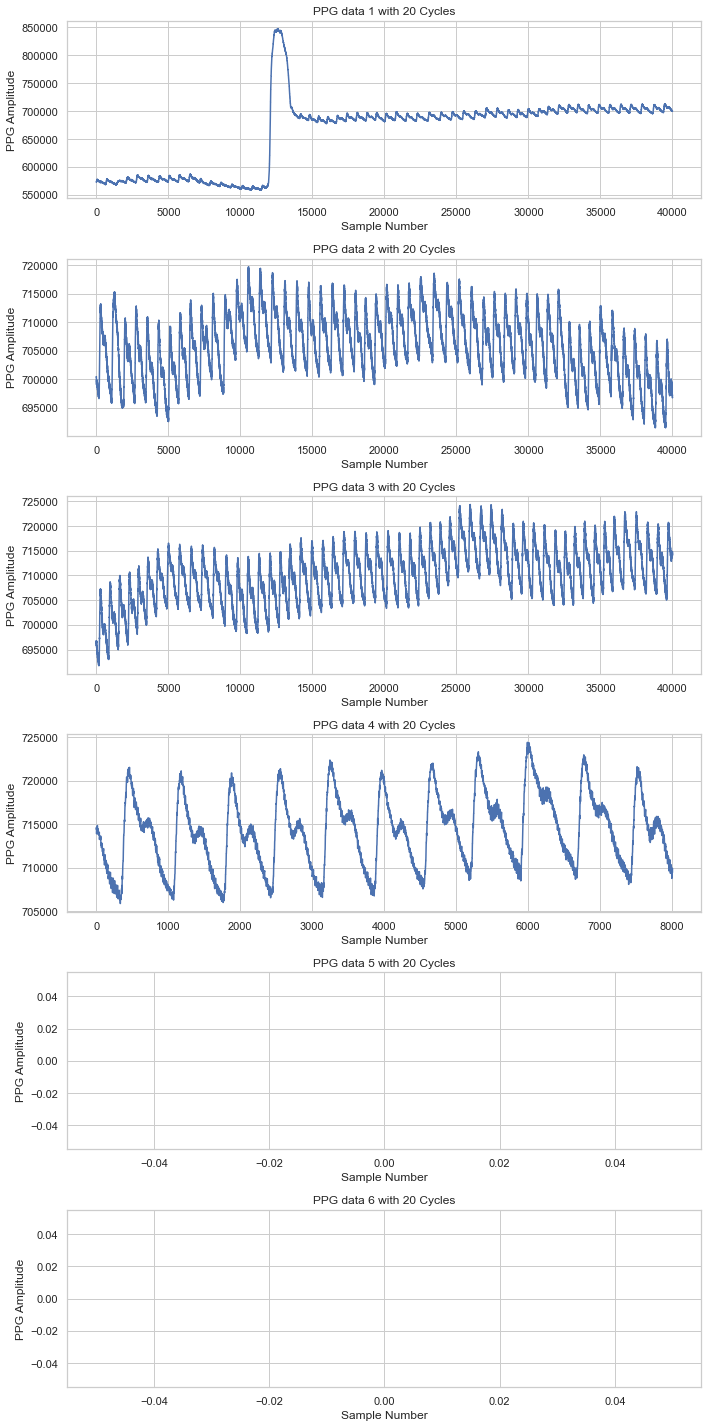

Loaded Successfully: True


In [177]:
import matplotlib.pyplot as plt
import pandas as pd

# 初始化变量
original_ppg = []
loaded_successfully = False
error_message = ''

try:
    
    file_path =r"C:\Users\HUAWEI\Desktop\datapack2.13\2.13_9人datapack\2.13_19.00_男_22_平静_坐姿_data2.txt"# 指定文件路径
   
    data = pd.read_csv(file_path, sep='\t', header=None, usecols=[0], skiprows=2)
    original_ppg = data[0].tolist()

    # 设置采样率等参数
    sampling_rate = 1000  # Hz
    cycle_duration = 1  
    points_per_cycle = 2000

    # 计算分割段
    cycles_per_segment = 20
    segments = [original_ppg[i * points_per_cycle * cycles_per_segment:(i + 1) * points_per_cycle * cycles_per_segment] for i in range(6)]

    # 绘图
    fig, axs = plt.subplots(6, 1, figsize=(10, 20))
    for i, segment in enumerate(segments):
        axs[i].plot(segment)
        axs[i].set_title(f'PPG data {i+1} with 20 Cycles')
        axs[i].set_xlabel('Sample Number')
        axs[i].set_ylabel('PPG Amplitude')

    plt.tight_layout()
    plt.show()

    loaded_successfully = True
except Exception as e:
    loaded_successfully = False
    error_message = str(e)

# 输出是否成功加载和错误消息
print("Loaded Successfully:", loaded_successfully)
if not loaded_successfully:
    print("Error Message:", error_message)


以上六个子图是对解包后的original_ppg数据绘图 观察各个波段PPG质量好坏 后续分析中需选择质量好的PPG数据进行分析

接下来选择截取质量好的PPG波段数据 将这一段数据进行后续分析 此时数据存储在 ppg_data中

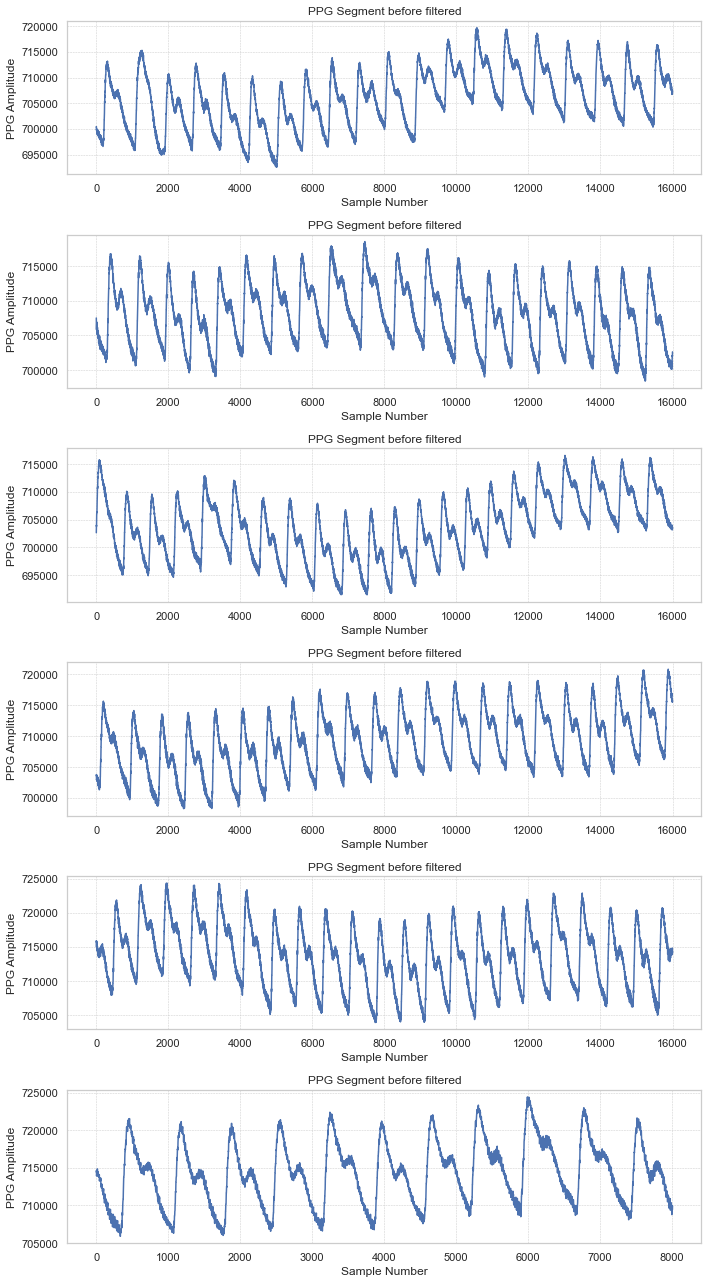

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# 假设 original_ppg 是已经加载的PPG数据
ppg_data = original_ppg[40000:]
cycles_per_segment = 20
points_per_cycle = 800
segments = [ppg_data[i * points_per_cycle * cycles_per_segment:(i + 1) * points_per_cycle * cycles_per_segment] for i in range(10)]

# 使用Seaborn来改进绘图风格
sns.set(style="whitegrid")

# 绘图时使用segments的长度来确定子图的数量，并确保它不超过6
num_subplots = min(len(segments), 6)  # 防止子图数量超过6
fig, axs = plt.subplots(num_subplots, 1, figsize=(10, num_subplots * 3), squeeze=False)  # 设置squeeze=False确保axs是2维数组
axs = axs.flatten()  # 将axs转换为1维数组以便于迭代



for i, segment in enumerate(segments[:num_subplots]):  # 也确保不迭代超过6次
    axs[i].plot(segment)  # 使用更柔和的颜色
    axs[i].set_title(f'PPG Segment before filtered')
    axs[i].set_xlabel('Sample Number')
    axs[i].set_ylabel('PPG Amplitude')
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)  # 添加网格

plt.tight_layout()
plt.show()


以上六个子图是选择数据质量较好的PPG波段进行绘制得到的子图  ppg_data

对PPG信号设置巴特沃斯3阶带通滤波器 通带1HZ到15HZ 绘制滤波后的PPG波形图与滤波器频率响应图 此时波形存储在filtered_ppg

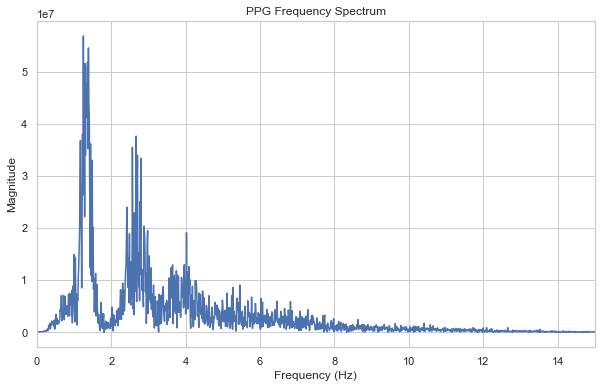

14668
88012


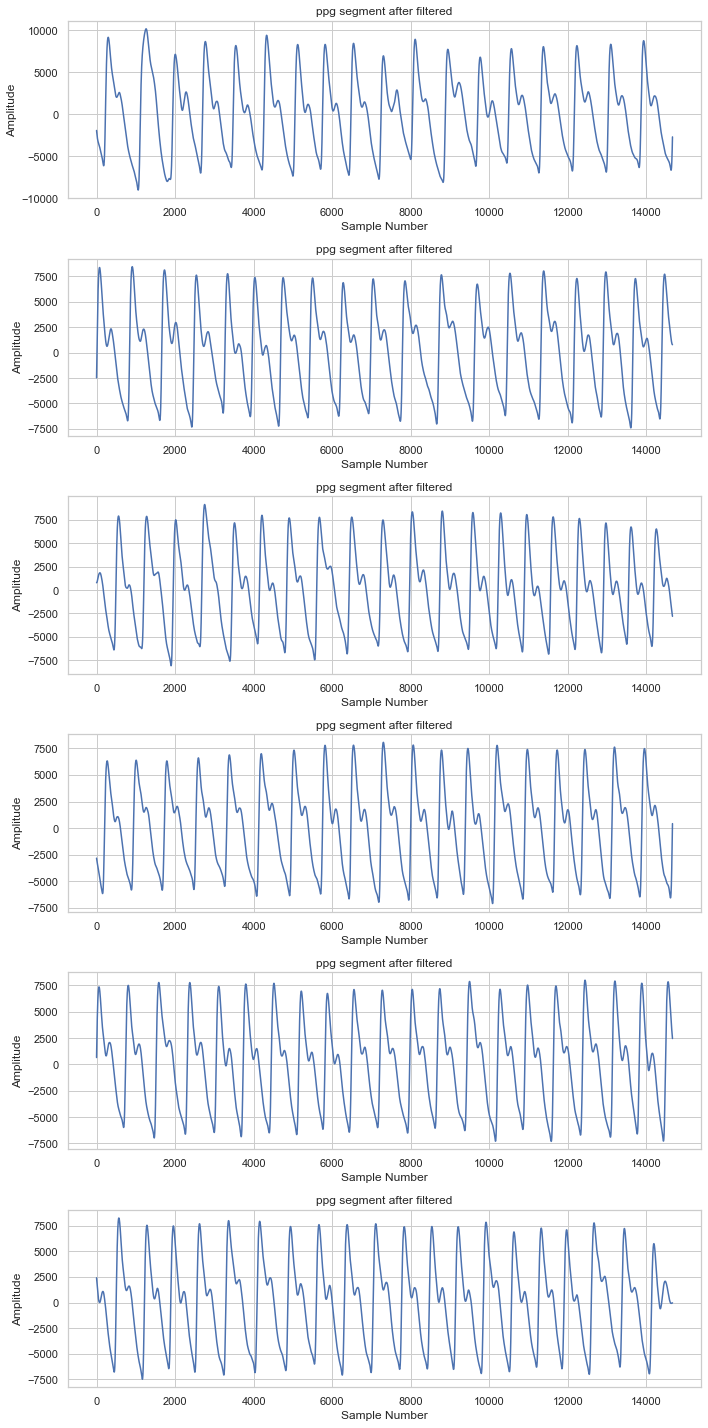

Ripple Suppression (dB): -inf


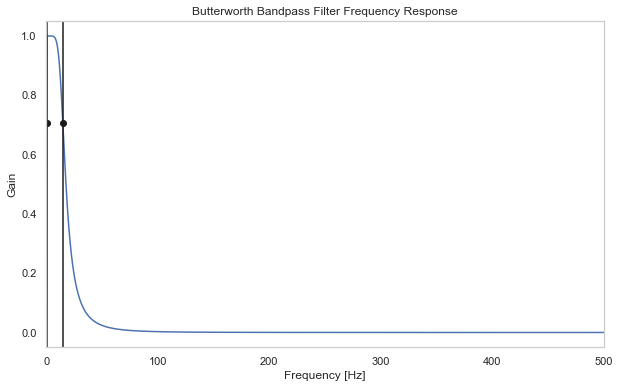

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# 高通和低通滤波器的参数设置
lowcut = 0.5  # 低通滤波器截止频率 HZ
highcut = 15  # 高通滤波器截止频率 HZ
sampling_rate = 1000  # 采样率，单位为Hz
order = 3  # 滤波器的阶数 不能过高 过高把大部分频率信息都丢失

# Butterworth滤波器函数 函数内参 lowcut低频截止频率 highcut高频截止频率 fs采样率 order结束 函数内参可直接调整传入函数
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# 使用Butterworth滤波器对数据进行滤波的函数 data传入函数需要调整的参数 lowcut highcut高低截止频率 fs采样率 order滤波器阶数
def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# 对PPG数据进行滤波 滤波后数据存储入filtered_ppg 
filtered_ppg = butter_bandpass_filter(ppg_data, lowcut, highcut, sampling_rate, order)
ppg_spectrum = np.fft.rfft(filtered_ppg)
frequencies = np.fft.rfftfreq(len(filtered_ppg), 1/sampling_rate)
# 绘制滤波后的PPG图像
ppg_spectrum = np.fft.rfft(filtered_ppg)
frequencies = np.fft.rfftfreq(len(filtered_ppg), 1/sampling_rate)
# 计算频谱的幅度
magnitude = np.abs(ppg_spectrum)

# 绘制频谱图
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitude)
plt.title('PPG Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 15)  # 展示 0-5Hz 的频谱范围 正常PPG波的基本频率应在1Hz（60次/分钟）到1.67Hz（100次/分钟）之间 低频包含的成分一般为呼吸成分
plt.grid(True)
plt.show()
# 分6个子图绘制滤波后的PPG图像
fig, axs = plt.subplots(6, 1, figsize=(10, 20))
points_per_segment = len(ppg_data) // 6
print(points_per_segment)
print(len(ppg_data))

for i in range(6):
    start_index = i * points_per_segment
    end_index = start_index + points_per_segment
    axs[i].plot(filtered_ppg[start_index:end_index])
    axs[i].set_title(f'ppg segment after filtered')
    axs[i].set_xlabel('Sample Number')
    axs[i].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, freqz

# 参数设置
lowcut = 0.5  # 低通滤波器截止频率 1 Hz
highcut = 15  # 高通滤波器截止频率 15 Hz
sampling_rate = 1000  # 采样率，单位为Hz
order = 3  # 滤波器的阶数

# 巴特沃斯带通滤波器设计
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# 定义滤波函数
def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# 设计滤波器并计算频率响应
b, a = butter_bandpass(lowcut, highcut, sampling_rate, order)
w, h = freqz(b, a, worN=8000)

# 绘制滤波器的频率响应图
plt.figure(figsize=(10, 6))
plt.plot(0.5 * sampling_rate * w / np.pi, np.abs(h), 'b')
plt.plot(lowcut, 0.5*np.sqrt(2), 'ko')
plt.plot(highcut, 0.5*np.sqrt(2), 'ko')
plt.axvline(lowcut, color='k')
plt.axvline(highcut, color='k')
plt.xlim(0, 0.5 * sampling_rate)
plt.title("Butterworth Bandpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()

# 计算纹波抑制比（在截止频率处）
ripple_suppression = 20 * np.log10(np.min(np.abs(h)))
print(f"Ripple Suppression (dB): {ripple_suppression:.2f}")

plt.show()



In [180]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import heartpy as hp
wd, m = hp.process(filtered_ppg, sample_rate = 1000.0)
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))
distances =60000 / m['bpm'] 
print(distances)

bpm: 79.783576
ibi: 752.034483
sdnn: 59.948531
sdsd: 29.716042
rmssd: 45.470870
pnn20: 0.626087
pnn50: 0.200000
hr_mad: 40.000000
sd1: 32.125824
sd2: 76.290638
s: 7699.728230
sd1/sd2: 0.421098
breathingrate: 0.133333
752.0344827586207


上图是PPG波滤波后绘制 filtered_ppg 以及滤波后频谱图 峰值代表心率频率 次峰值一般代表二尖瓣波值频率 其他高阶高频成分 

PPG波中低频的成分表征基线漂移 也表征呼吸成分 使用巴特斯沃滤波器提取 此时实验体使用呼吸机非自主呼吸 提取出数据存储在ppg_breathing中

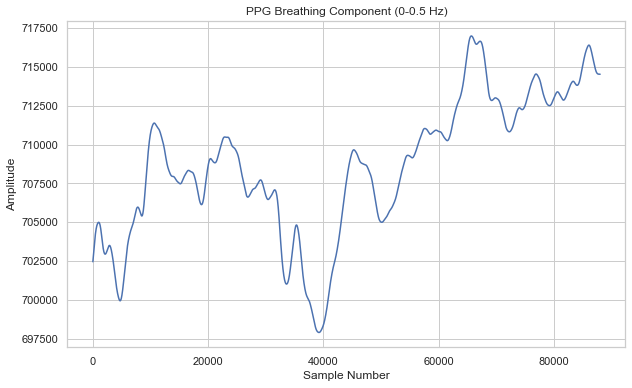

In [181]:
#提取低频基线漂移表征呼吸的成分 进行低通滤波
# 设置低通滤波器的参数
lowcut_breathing = 0.5  # 低通滤波器截止频率，单位为Hz

# Butterworth滤波器设计函数，用于低通滤波
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# 使用Butterworth滤波器对数据进行低通滤波的函数
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# 对PPG数据进行低通滤波以提取呼吸成分
ppg_breathing = butter_lowpass_filter(ppg_data, lowcut_breathing, sampling_rate, order)

# 绘制滤波后的PPG呼吸成分图像
plt.figure(figsize=(10, 6))
plt.plot(ppg_breathing)
plt.title('PPG Breathing Component (0-0.5 Hz)')

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.show()






上图是PPG中低频呼吸成分 基线漂移 周期一般代表呼吸分量

使用自相关函数方法 提出质量不好的PPG波形 自相关波形的峰值若有明显周期性 则说明波段周期性良好 设置不好的波形在自相关函数的第一个峰值之前 绘制自相关图以及剔除不好波形后的PPG 此时数据存储在ppg_filtered_new

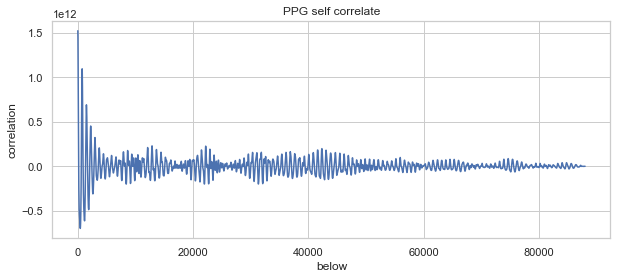

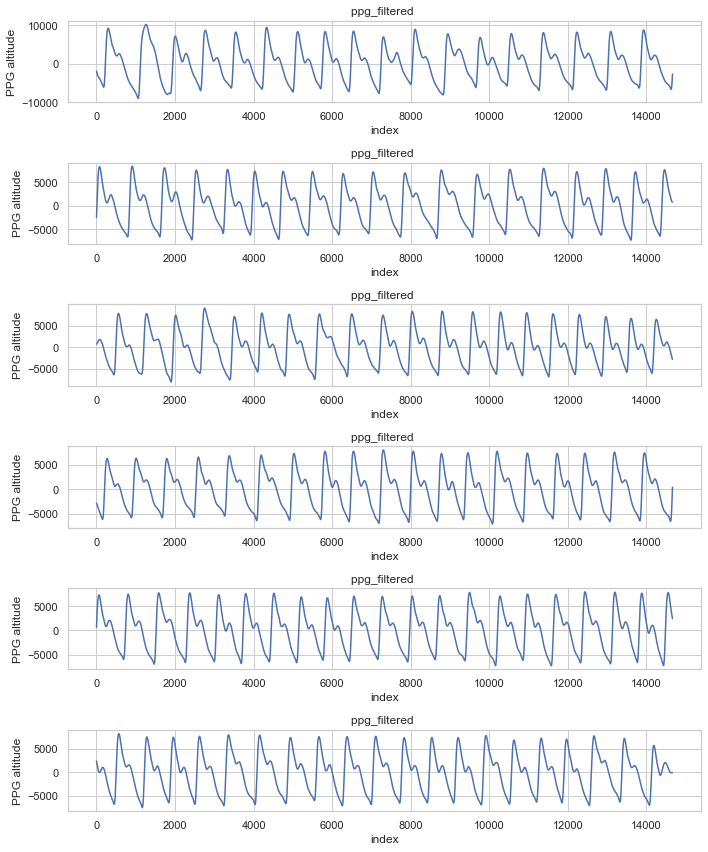

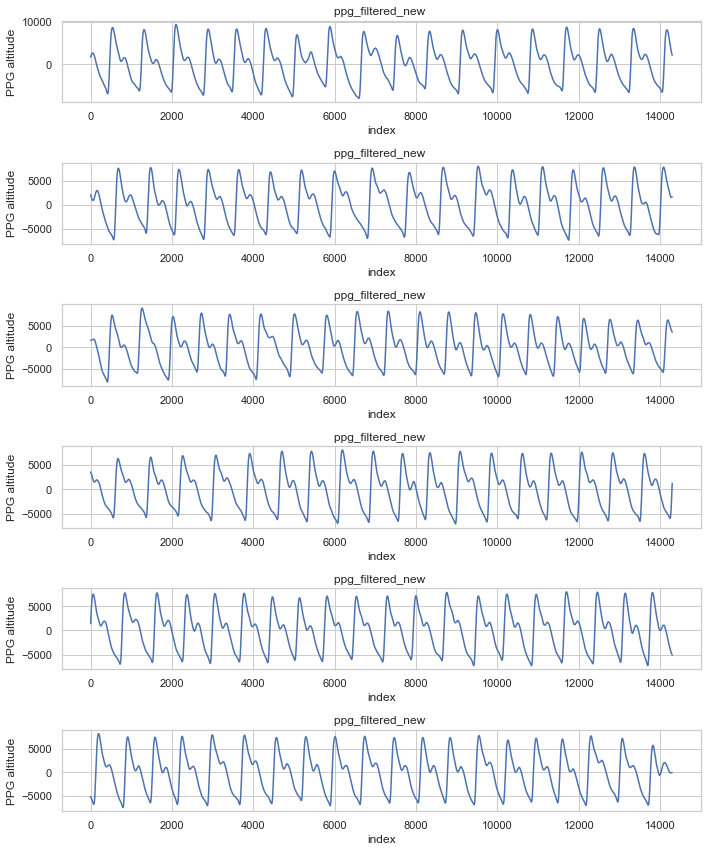

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

ppg_filtered = filtered_ppg

# 计算自相关函数
autocorr = np.correlate(ppg_filtered, ppg_filtered, mode='full')
autocorr = autocorr[autocorr.size // 2:]  # 取自相关的一半

# 检测波形质量 使用自相关的峰值
# 找到除零延迟之外的峰值
peaks, _ = find_peaks(autocorr, distance = distances)  # distance参数根据PPG信号的特性调整

# 如果找到多个峰值，考虑第一个非零延迟峰值
if len(peaks) > 1:
    quality_peak = peaks[1]  # 第一个非零延迟峰值
    ppg_filtered_new = ppg_filtered[quality_peak:]
else:
    print("未找到合适的峰值，保留原始数据。")
    ppg_filtered_new = ppg_filtered
    quality_peak = 0

# 绘制自相关图
plt.figure(figsize=(10, 4))
plt.plot(autocorr)
plt.title('PPG self correlate')
plt.xlabel('below')
plt.ylabel('correlation')
plt.show()

# 将ppg_filtered分为6个子图绘制
subplots = 6
samples_per_subplot = len(ppg_filtered) // subplots

fig, axes = plt.subplots(subplots, 1, figsize=(10, 12))
for i in range(subplots):
    axes[i].plot(ppg_filtered[i * samples_per_subplot: (i + 1) * samples_per_subplot])
    axes[i].set_title(f'ppg_filtered ')
    axes[i].set_xlabel('index')
    axes[i].set_ylabel('PPG altitude')
plt.tight_layout()
plt.show()

# 将ppg_filtered_new分为6个子图绘制，并标注剔除的部分
samples_per_subplot_new = len(ppg_filtered_new) // subplots

fig, axes = plt.subplots(subplots, 1, figsize=(10, 12))
for i in range(subplots):
    start_index = i * samples_per_subplot_new
    end_index = (i + 1) * samples_per_subplot_new
    axes[i].plot(ppg_filtered_new[start_index: end_index])
    axes[i].set_title(f'ppg_filtered_new ')
    axes[i].set_xlabel('index')
    axes[i].set_ylabel('PPG altitude')
    
plt.tight_layout()
plt.show()


上图是自相关波形以及ppg_filtered_new波形的绘制

以上是对ppg_filtered_new初步标注峰值谷值的图像 输出初步周期 依据初步周期设置峰峰值最小间隔参数 distance参数 避免将局部最小值错误标注为峰值谷值 distance参数依据绘图后结果调整 调整后重新标注峰值谷值并绘图 提取呼吸周期与呼吸周期变异率

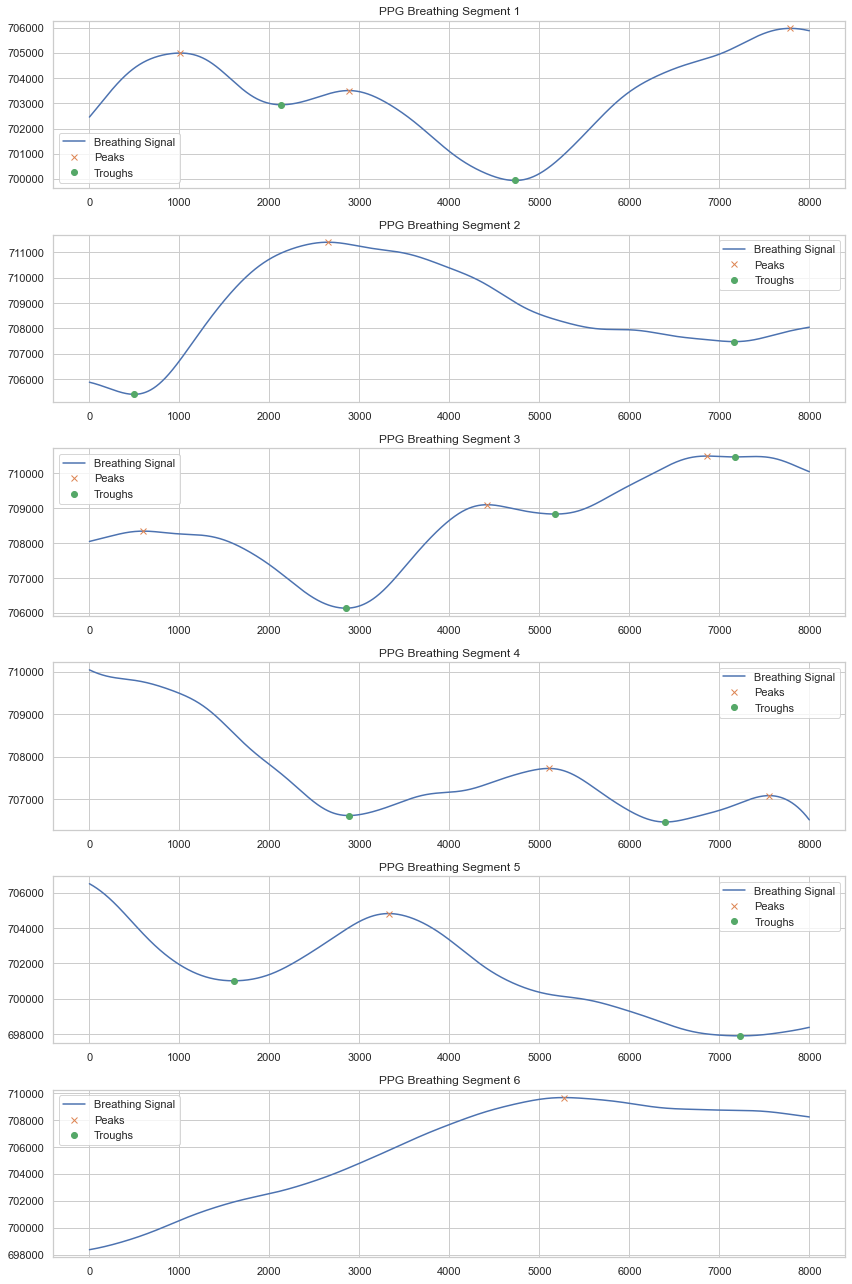

4.050333333333334
0.5568036648870598
[1.872 4.908 2.861 5.949 3.821 2.443 6.241 2.449 3.772 9.947 9.363 2.96
 1.949 6.124 1.523 2.646 4.163 2.892 3.723 2.718 2.733]
[1872 4908 2861 5949 3821 2443 6241 2449 3772 9947 9363 2960 1949 6124
 1523 2646 4163 2892 3723 2718 2733]


In [183]:
# 为确保每个周期内只有一个峰值和一个谷值，我们将调整峰值和谷值的提取方法
# 假定每个呼吸周期至少持续2秒钟基于正常的呼吸频率

min_distance_between_peaks = int(distances)  # 最小峰值间距设为4秒

# 使用find_peaks函数，增加distance参数以确保每个周期内只检测到一个峰值和谷值
peaks_breathing, _ = find_peaks(ppg_breathing, distance=min_distance_between_peaks)
troughs_breathing, _ = find_peaks(-ppg_breathing, distance=min_distance_between_peaks)
breathing_intervals = np.diff(peaks_breathing)
average_breathing_intervalnew = np.mean(breathing_intervals) / sampling_rate #呼吸平均周期
breathing_periods = np.diff(peaks_breathing) / sampling_rate  
breathing_period_variability = np.std(breathing_periods) / np.mean(breathing_periods) #呼吸周期变异率
# 分6个子图绘制调整后的峰值和谷值
# 修改峰值和谷值索引的处理方式，以避免索引越界的错误

fig, axs = plt.subplots(6, 1, figsize=(12, 18))
points_per_segment_breathing = 8000
for i in range(6):
    start_index = i * points_per_segment_breathing
    end_index = start_index + points_per_segment_breathing
    segment_breathing = ppg_breathing[start_index:end_index]

    # 确保峰值和谷值索引在当前分段的范围内
    segment_peaks = [peak for peak in peaks_breathing if start_index <= peak < end_index]
    segment_troughs = [trough for trough in troughs_breathing if start_index <= trough < end_index]

    # 将全局索引转换为当前分段的相对索引
    segment_peaks_relative = [peak - start_index for peak in segment_peaks]
    segment_troughs_relative = [trough - start_index for trough in segment_troughs]

    axs[i].plot(segment_breathing, label='Breathing Signal')
    axs[i].plot(segment_peaks_relative, segment_breathing[segment_peaks_relative], 'x', label='Peaks')
    axs[i].plot(segment_troughs_relative, segment_breathing[segment_troughs_relative], 'o', label='Troughs')
    axs[i].set_title(f'PPG Breathing Segment {i+1}')
    axs[i].legend()

plt.tight_layout()
plt.show()
print(average_breathing_intervalnew)
print(breathing_period_variability)
print(breathing_periods)
print(breathing_intervals)
#输出呼吸周期均值 呼吸周期变异率

对 0.5HZ-15HZ PPG波形做相同处理 distance参数可调 重新标注峰值谷值并绘图 提取精确周期与心率变异率

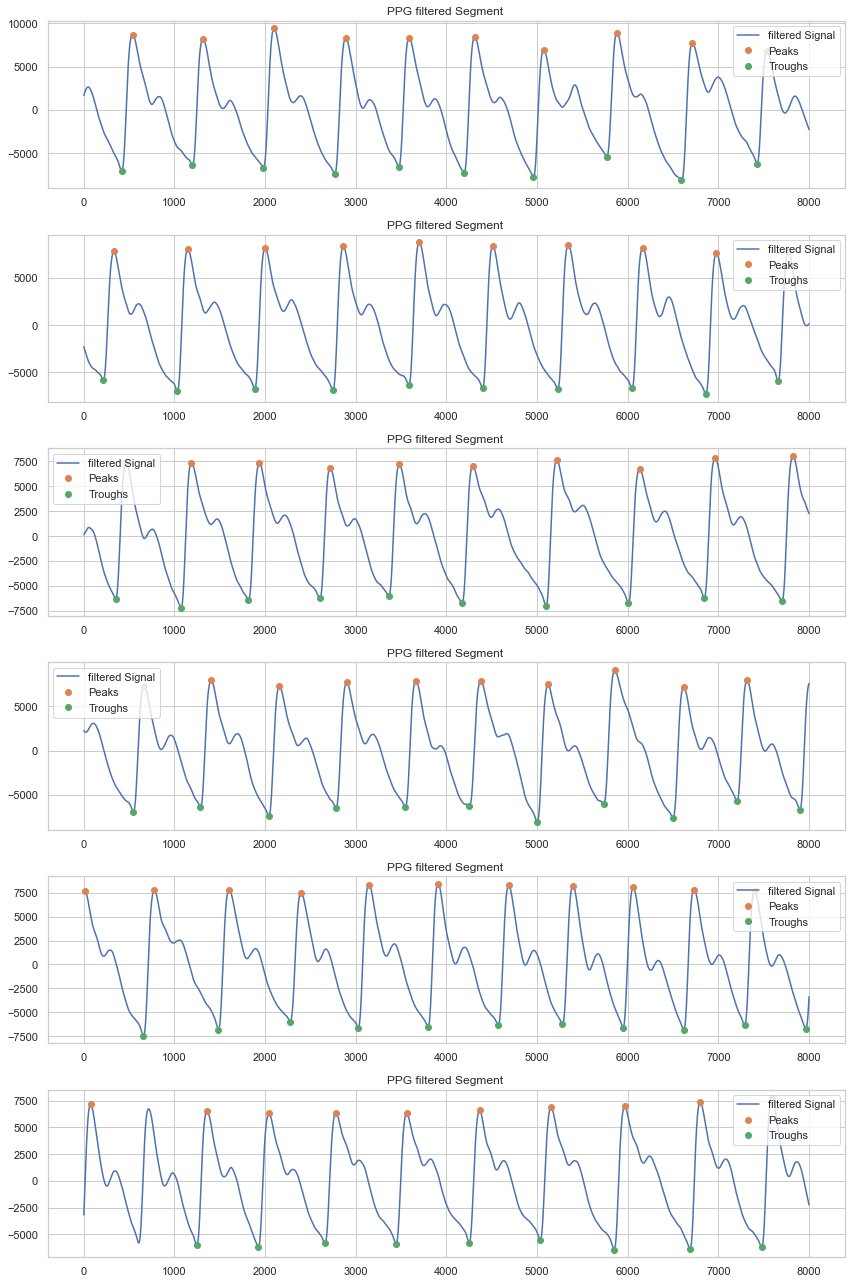

0.7636216216216216
0.12140887600347858
[0.776 0.785 0.79  0.699 0.724 0.76  0.809 0.832 0.825 0.794 0.815 0.853
 0.863 0.836 0.812 0.833 0.821 0.812 0.795 0.695 0.72  0.75  0.779 0.764
 0.81  0.927 0.913 0.833 0.859 0.845 0.739 0.752 0.742 0.763 0.716 0.741
 0.735 0.761 0.699 0.694 0.769 0.824 0.795 0.748 0.763 0.778 0.709 0.664
 0.671 0.668 0.676 1.284 0.684 0.738 0.781 0.804 0.788 0.813 0.833 0.791
 0.724 0.761 0.761 0.72  0.672 0.743 0.772 0.758 0.708 0.752 0.763 0.778
 0.744 0.778 0.79  0.737 0.689 0.716 0.698 0.665 0.676 0.721 0.763 0.701
 0.758 0.776 0.702 0.721 0.742 0.761 0.684 0.671 0.68  0.715 0.673 0.666
 0.741 0.792 0.784 0.725 0.718 0.729 0.724 0.705 0.669 0.709 0.712 0.694
 1.346 0.772 0.751]
[ 776  785  790  699  724  760  809  832  825  794  815  853  863  836
  812  833  821  812  795  695  720  750  779  764  810  927  913  833
  859  845  739  752  742  763  716  741  735  761  699  694  769  824
  795  748  763  778  709  664  671  668  676 1284  684  738  781  804


In [184]:
# 为确保每个周期内只有一个峰值和一个谷值，我们将调整峰值和谷值的提取方法
# 假定每个PPG周期至少持续0.5秒钟
distances = distances- 100
ppg_filtered=ppg_filtered_new
points_per_segment_filtered=points_per_segment_breathing
min_distance_between_peaks = int(distances)  # 最小峰值间距设为0.5秒

# 使用find_peaks函数，增加distance参数以确保每个周期内只检测到一个峰值和谷值
peaks_filtered, _ = find_peaks(ppg_filtered, distance=min_distance_between_peaks)
troughs_filtered, _ = find_peaks(-ppg_filtered, distance=min_distance_between_peaks)
filtered_intervals = np.diff(peaks_filtered)
average_filtered_interval = np.mean(filtered_intervals) / sampling_rate #呼吸平均周期
filtered_periods = np.diff(peaks_filtered) / sampling_rate  
filtered_period_variability = np.std(filtered_periods) / np.mean(filtered_periods) #呼吸周期变异率
# 分6个子图绘制调整后的峰值和谷值
# 修改峰值和谷值索引的处理方式，以避免索引越界的错误

fig, axs = plt.subplots(6, 1, figsize=(12, 18))

for i in range(6):
    start_index = i * points_per_segment_filtered
    end_index = start_index + points_per_segment_filtered
    segment_filtered = ppg_filtered[start_index:end_index]

    # 确保峰值和谷值索引在当前分段的范围内
    segment_peaks = [peak for peak in peaks_filtered if start_index <= peak < end_index]
    segment_troughs = [trough for trough in troughs_filtered if start_index <= trough < end_index]

    # 将全局索引转换为当前分段的相对索引
    segment_peaks_relative = [peak - start_index for peak in segment_peaks]
    segment_troughs_relative = [trough - start_index for trough in segment_troughs]

    axs[i].plot(segment_filtered, label='filtered Signal')
    axs[i].plot(segment_peaks_relative, segment_filtered[segment_peaks_relative], 'o', label='Peaks')
    axs[i].plot(segment_troughs_relative, segment_filtered[segment_troughs_relative], 'o', label='Troughs')
    axs[i].set_title(f'PPG filtered Segment ')
    axs[i].legend()

plt.tight_layout()
plt.show()
print(average_filtered_interval)
print(filtered_period_variability)
print(filtered_periods)
print(filtered_intervals)


提取PPG波的直流分量与交流分量 先提取A1表征交流分量的峰峰值 A2表征二尖瓣降波值（峰值之后第一个曲率为零的点与谷值之间垂直距离）A3表征直流分量 对于A3的提取使用原始数据中DC分量直流均值 对于A1,A2的提取 由于有的PPG波中不存在二尖瓣波值 需选择完好的波形

首先提取DC分量 用orinal_ppg的数据均值作为直流分量

In [185]:
# 提取DC分量 - 使用原始PPG数据的直流均值 原始没有经过滤波的PPG数据中包含原始DC分量信息 滤波去除低频分量会滤除DC信息
DC_value = np.mean(ppg_data)
print(DC_value)


708637.8626323683


提取交流振幅分量 两个波谷界定一个周期 周期中波峰与较低波谷的垂直距离作为振幅分量

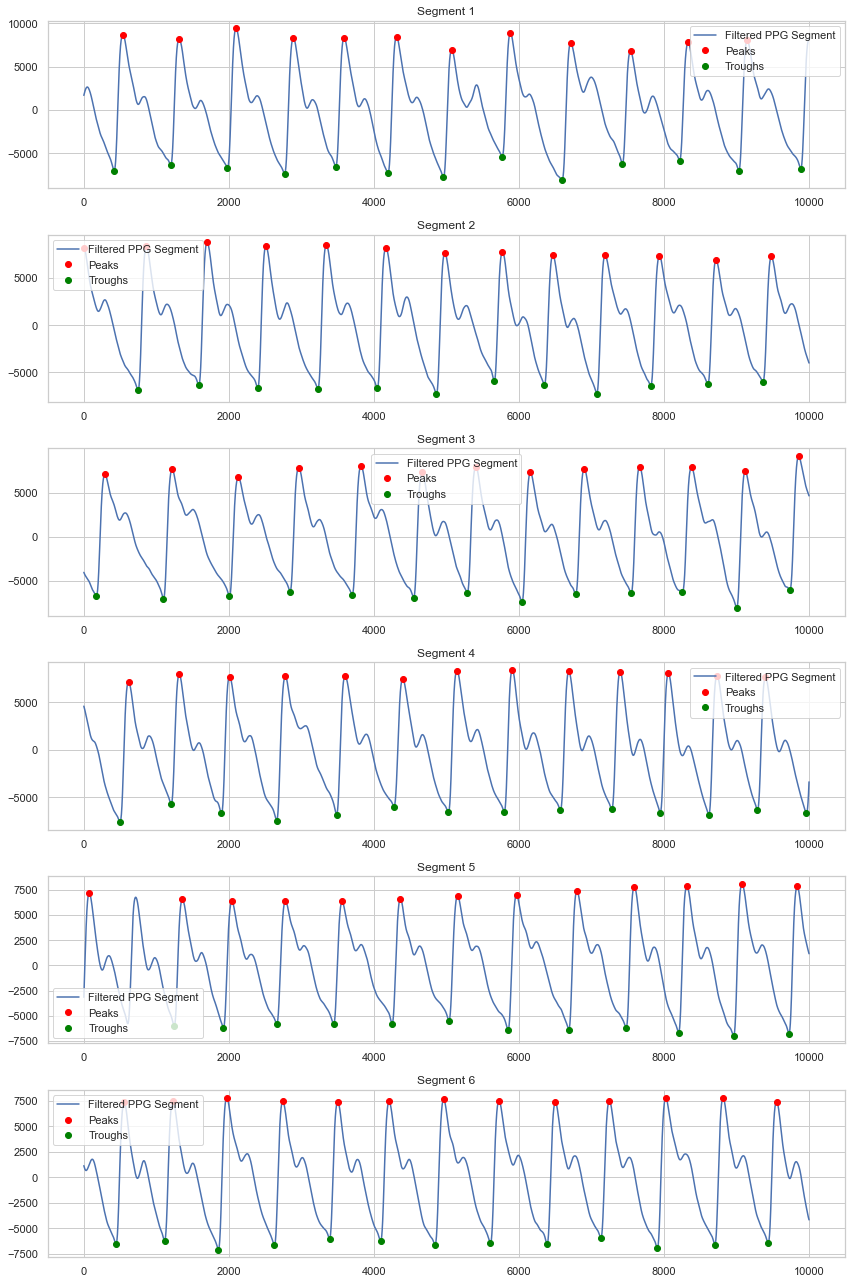

14232.422701479501
[15675.534632409624, 14530.085628248078, 16044.01644126623, 15677.35070983175, 14874.308916228783, 15720.566843808198, 14706.320976043102, 14313.966515319189, 15856.095482409175, 12997.521770534608, 13636.845481387398, 15043.42919209771, 14932.82700766321, 15238.359582799147, 15111.311808473929, 15056.82529262993, 15170.859015049005, 14802.080133272451, 14946.033685043789, 13714.690301466053, 13695.069871974454, 14609.344616743005, 13758.186554135531, 13138.903116730622, 13257.902437523078, 13817.906776451691, 14682.124819181128, 13493.219813333895, 14011.639052620103, 14588.914070883779, 14207.626085498126, 14281.68294299789, 14695.23970188294, 14243.789046082104, 14298.309088448015, 14127.848684953082, 15582.34804571767, 15178.134243317169, 14775.929428209454, 13725.379186117929, 14392.174549523934, 15228.757475891789, 14603.958975870722, 13463.485147210904, 14936.869657757554, 14981.836788328872, 14614.464523111983, 14497.193037380395, 14666.283386256511, 14656.15

In [186]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 设置最小峰值和谷值间隔，一个周期至少持续0.5秒，采样率为500Hz
min_peak_distance = distances # 0.5秒对应的采样点数

# 使用find_peaks找到满足条件的峰值
peaks, _ = find_peaks(ppg_filtered, distance=min_peak_distance)

# 使用find_peaks找到满足条件的谷值
troughs, _ = find_peaks(-ppg_filtered, distance=min_peak_distance)

# 计算每个峰值和相邻谷值之间的差值（峰峰值）
peak_to_trough_amplitudes = [ppg_filtered[peak] - ppg_filtered[troughs[np.argmax(troughs > peak) - 1]] for peak in peaks if np.argmax(troughs > peak) > 0]

# 计算A1，即峰峰值的平均值
Altitude = np.mean(peak_to_trough_amplitudes) if peak_to_trough_amplitudes else 0

fig, axs = plt.subplots(6, 1, figsize=(12, 18))
segment_length = 10000
for i in range(6):
    start_index = i * segment_length
    end_index = start_index + segment_length
    segment = ppg_filtered[start_index:end_index]

    # 调整峰值和谷值的索引，确保它们位于当前分段内
    segment_peaks = [peak - start_index for peak in peaks if start_index <= peak < end_index]
    segment_troughs = [trough - start_index for trough in troughs if start_index <= trough < end_index]

    axs[i].plot(segment, label='Filtered PPG Segment')
    axs[i].plot(segment_peaks, segment[segment_peaks], 'o', label='Peaks', color='red')
    axs[i].plot(segment_troughs, segment[segment_troughs], 'o', label='Troughs', color='green')
    axs[i].set_title(f'Segment {i+1}')
    axs[i].legend()

plt.tight_layout()
plt.show()

# 输出A1的值
print(Altitude)
print(peak_to_trough_amplitudes)



振幅随时间呈现规律性变化 反映低频心脏的泵血效率 振幅变化周期提取出来 (其实是呼吸的基频）

0.0


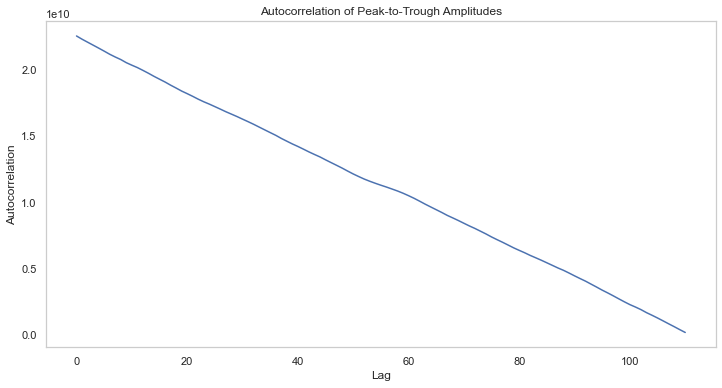

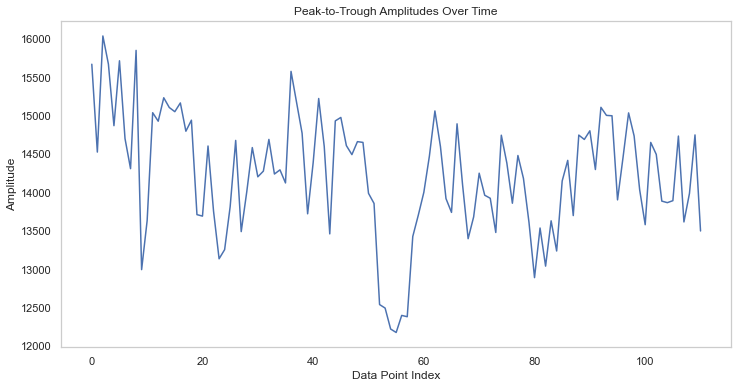

In [187]:
from scipy.signal import correlate, find_peaks
import matplotlib.pyplot as plt

# 计算自相关
auto_corr = correlate(peak_to_trough_amplitudes, peak_to_trough_amplitudes, mode='full')
center = len(auto_corr) // 2

# 从自相关的中心开始寻找第一个峰值，这个峰值代表了周期的长度
auto_corr_peaks, _ = find_peaks(auto_corr[center:])

# 检查是否找到显著的峰值
if len(auto_corr_peaks) > 10:
    # 第一个峰值的位置即为周期
    period = auto_corr_peaks[0]
else:
    # 没有找到显著的峰值，将周期设置为0
    period = 0

# 根据周期计算其他相关参数
period_true = period * 0.57
print(period_true)

# 绘制自相关结果
plt.figure(figsize=(12, 6))
plt.plot(auto_corr[center:center + 2 * period] if period > 0 else auto_corr[center:])
plt.title('Autocorrelation of Peak-to-Trough Amplitudes')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid()
plt.show()

# 绘制原始数据
plt.figure(figsize=(12, 6))
plt.plot(peak_to_trough_amplitudes)
plt.title('Peak-to-Trough Amplitudes Over Time')
plt.xlabel('Data Point Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


提取二尖瓣波值 方法：首先先将峰值与谷值在图中标注出来，然后寻找峰值与下一个峰值之间所有局部最小值点（一阶导数为零，并且这个点要排除掉谷值）然后输出并比较他们二阶导数的大小，最后选择二阶导最大的点标注出来 然后增加约束条件 这个点与周期内峰值的垂直距离大于1/3振幅 与周期内谷值距离大于1/3振幅 选择列表中符合条件且一阶导数为0二阶导数最大的点作为二尖瓣波值点

先观察 选择有明显二尖瓣波值的波段存储在ppg_segment中并绘图

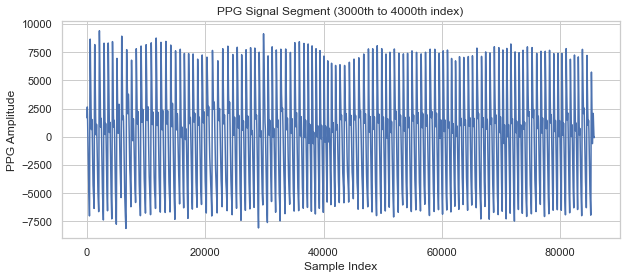

In [188]:
ppg_segment = ppg_filtered_new

# Plot the segment
plt.figure(figsize=(10, 4))
plt.plot(ppg_segment)
plt.title('PPG Signal Segment (3000th to 4000th index)')
plt.xlabel('Sample Index')
plt.ylabel('PPG Amplitude')
plt.grid(True)
plt.show()

开始标注二尖瓣波值 标注好后绘图 输出二尖瓣波值与周期内谷值距离列表

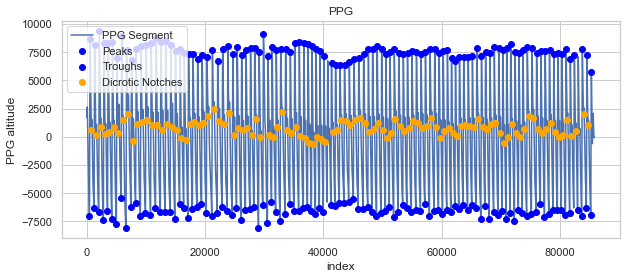

二尖瓣波值垂直距离差值列表: [7659.244612427932, 6526.326688541193, 7494.48172434428, 7585.454186646647, 6942.970122276128, 8124.051953853422, 8067.832497906419, 6897.49879551371, 10173.22486871648, 5858.080906818795, 6965.127983034551, 8274.451789057723, 8215.549123969244, 7994.0268912077045, 7358.8973143077355, 7301.842115830062, 7826.771688899728, 7567.823867486858, 7930.729287617672, 5885.506983009056, 6056.049494778271, 8394.709173932564, 7700.052075926475, 7271.855322488498, 7243.078497324611, 8640.97104497177, 9462.783927345245, 8184.692272755325, 7327.422177585373, 8638.27255131806, 7031.094308365821, 7120.30664087777, 7975.4656947834155, 7304.715456690228, 6587.700609499467, 7818.031089946033, 8063.336473263282, 7746.515331393237, 5686.39165969474, 7550.461430963023, 9700.150314818324, 7425.447281315509, 6281.772335096175, 7469.071481329162, 6621.224158785035, 6267.98993308652, 5690.062973948653, 6000.000161197435, 6849.717363603439, 6166.723289246935, 6226.622688362398, 6409.880663800075, 

In [189]:
import numpy as np
from scipy.signal import find_peaks, argrelextrema

import numpy as np
from scipy.signal import find_peaks, argrelextrema
#ppg_segment = np.array(ppg_data)
#赋值 列表转化为数组


    
def find_dicrotic_notches_corrected(signal):
    
    peaks, _ = find_peaks(signal, distance = distances)
    troughs, _ = find_peaks(-signal, distance = distances)

    # 计算信号的一阶和二阶导数
    first_derivative = np.diff(signal)
    second_derivative = np.diff(first_derivative)
    
    # 初始化二尖瓣波值列表
    dicrotic_notches = []

    # 遍历每个峰值，寻找它和下一个峰值之间的所有局部最小值点
    for i in range(len(peaks) - 1):
        # 检查i+1是否在troughs数组的索引范围内
        if i + 1 < len(troughs):
            # 在当前峰值和下一个峰值之间找到所有的局部最小值点
            local_minima = argrelextrema(signal[peaks[i]:peaks[i+1]], np.less)[0] + peaks[i]
            # 排除谷值
            local_minima = [index for index in local_minima if index not in troughs]

            # 初始化用于比较的二阶导数最大值
            max_second_derivative = -np.inf
            # 初始化用于记录当前最优的二尖瓣波值索引
            best_notch = None

            # 遍历局部最小值点，找出二阶导数最大且符合振幅条件的点
            for local_minimum in local_minima:
                # 确保local_minimum不超出signal的索引范围
                if local_minimum < len(signal) and local_minimum - 1 < len(second_derivative):
                    # 检查与波峰和波谷的振幅条件
                    amplitude_condition_peak = abs(signal[peaks[i]] - signal[local_minimum]) > (abs(signal[peaks[i]] - signal[troughs[i]]) / 5)
                    amplitude_condition_trough = abs(signal[troughs[i+1]] - signal[local_minimum]) > (abs(signal[troughs[i+1]] - signal[peaks[i+1]]) / 5)
                    amplitude_condition = amplitude_condition_peak and amplitude_condition_trough

                    # 检查二阶导数的大小，并更新最优值
                    if second_derivative[local_minimum - 1] > max_second_derivative and amplitude_condition:
                        max_second_derivative = second_derivative[local_minimum - 1]
                        best_notch = local_minimum

            # 如果在当前峰值和下一个峰值之间找到了最优的二尖瓣波值点，将它加入列表
            if best_notch is not None:
                dicrotic_notches.append(best_notch)

    return peaks, troughs, dicrotic_notches


# 调用函数并绘制结果
peaks, troughs, dicrotic_notches = find_dicrotic_notches_corrected(ppg_segment)

# 绘制原始信号，并标注峰值和谷值
plt.figure(figsize=(10, 4))
plt.plot(ppg_segment, label='PPG Segment')
plt.scatter(peaks, ppg_segment[peaks], color='blue', marker='o', zorder=5, label='Peaks')
plt.scatter(troughs, ppg_segment[troughs], color='blue', marker='o', zorder=5, label='Troughs')
# 标注二尖瓣波值
plt.scatter(dicrotic_notches, ppg_segment[dicrotic_notches], color='orange', zorder=5, label='Dicrotic Notches')
plt.title('PPG')
plt.xlabel('index')
plt.ylabel('PPG altitude')
plt.legend()
plt.grid(True)
plt.show()

# 输出二尖瓣波值的索引和对应的PPG幅度值
dicrotic_notches, ppg_segment[dicrotic_notches]

# 计算二尖瓣波值点与其最邻近的谷值的点的垂直距离差值
def calculate_vertical_distances(signal, notches, troughs):
    vertical_distances = []
    for notch in notches:
        # 找到最邻近的谷值
        nearest_trough = min(troughs, key=lambda x: abs(x - notch))
        # 计算垂直距离差值
        vertical_distance = abs(signal[notch] - signal[nearest_trough])
        vertical_distances.append(vertical_distance)
    return vertical_distances

# 计算距离并存储在列表中
vertical_distances = calculate_vertical_distances(ppg_segment, dicrotic_notches, troughs)

# 打印列表内数据
print("二尖瓣波值垂直距离差值列表:", vertical_distances)

# 计算平均值并打印
if len(vertical_distances) == 0:
    average_distance = 0
else:
    average_distance = sum(vertical_distances) / len(vertical_distances)
print("二尖瓣波值平均垂直距离差值:", average_distance)
R=Altitude/DC_value
R2=average_distance/DC_value
print(R)
print(R2)

以下代码验证二尖瓣波值是否在PPG波形周期中有确定的位置 并使用0.95置信度t检验

二尖瓣与第一个波谷的水平距离与周期长度的比值： [0.4282051282051282, 0.43167305236270753, 0.41804320203303685, 0.4405099150141643, 0.4444444444444444, 0.4366013071895425, 0.3967861557478368, 0.3890909090909091, 0.354916067146283, 0.38910012674271227, 0.3700980392156863, 0.3629976580796253, 0.3677494199535963, 0.37589498806682575, 0.3726937269372694, 0.36550060313630883, 0.39194139194139194, 0.3754601226993865, 0.38095238095238093, 0.45007235890014474, 0.44182825484764543, 0.4435483870967742, 0.40533672172808133, 0.3986842105263158, 0.3811881188118812, 0.34735706580366776, 0.3487348734873487, 0.3672248803827751, 0.3773364485981308, 0.38089622641509435, 0.41271989174560214, 0.42119205298013246, 0.4337837837837838, 0.42091503267973857, 0.4765957446808511, 0.4266666666666667, 0.4693042291950887, 0.43909348441926344, 0.44668587896253603, 0.42105263157894735, 0.39903264812575573, 0.3969658659924147, 0.408, 0.4025974025974026, 0.3909677419354839, 0.422316384180791, 0.44461077844311375, 0.4582089552238806, 0.46348733

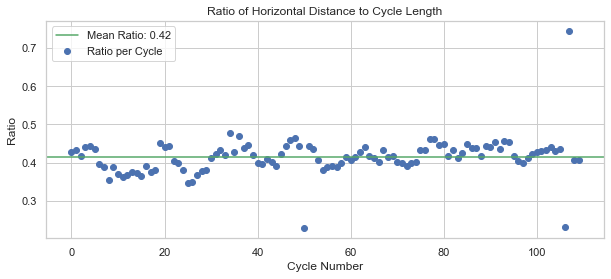

二尖瓣波值与波谷的水平距离比值: [0.4282051282051282, 0.43167305236270753, 0.41804320203303685, 0.4405099150141643, 0.4444444444444444, 0.4366013071895425, 0.3967861557478368, 0.3890909090909091, 0.354916067146283, 0.38910012674271227, 0.3700980392156863, 0.3629976580796253, 0.3677494199535963, 0.37589498806682575, 0.3726937269372694, 0.36550060313630883, 0.39194139194139194, 0.3754601226993865, 0.38095238095238093, 0.45007235890014474, 0.44182825484764543, 0.4435483870967742, 0.40533672172808133, 0.3986842105263158, 0.3811881188118812, 0.34735706580366776, 0.3487348734873487, 0.3672248803827751, 0.3773364485981308, 0.38089622641509435, 0.41271989174560214, 0.42119205298013246, 0.4337837837837838, 0.42091503267973857, 0.4765957446808511, 0.4266666666666667, 0.4693042291950887, 0.43909348441926344, 0.44668587896253603, 0.42105263157894735, 0.39903264812575573, 0.3969658659924147, 0.408, 0.4025974025974026, 0.3909677419354839, 0.422316384180791, 0.44461077844311375, 0.4582089552238806, 0.463487332339791

In [190]:
import matplotlib.pyplot as plt
from scipy import stats
# 计算二尖瓣波值点与周期内第一个波谷的水平距离与整个周期长度的比值
def calculate_ratio(signal, notches, troughs):
    ratios = []

    for notch in notches:
        # 确定在当前二尖瓣波值之前和之后最近的波谷
        previous_troughs = [trough for trough in troughs if trough < notch]
        next_troughs = [trough for trough in troughs if trough > notch]

        if previous_troughs and next_troughs:
            # 找到最近的前一个和后一个波谷
            nearest_previous_trough = max(previous_troughs)
            nearest_next_trough = min(next_troughs)

            # 计算两个波谷之间的水平距离（周期长度）
            cycle_length = nearest_next_trough - nearest_previous_trough

            # 计算二尖瓣波值点与最近前一个波谷之间的水平距离
            horizontal_distance = notch - nearest_previous_trough

            # 计算比值
            if cycle_length != 0:
                ratio = horizontal_distance / cycle_length
                ratios.append(ratio)

    return ratios


# 计算比值
ratios = calculate_ratio(ppg_data, dicrotic_notches, troughs)

# 检验比值是否在一定的置信区间定值
mean_ratio = np.mean(ratios)
std_ratio = np.std(ratios)

# 打印结果
print("二尖瓣与第一个波谷的水平距离与周期长度的比值：", ratios)
print("平均比值：", mean_ratio)
print("标准差：", std_ratio)

# 绘制散点图展示每个周期的比值
plt.figure(figsize=(10, 4))
plt.scatter(range(len(ratios)), ratios, label='Ratio per Cycle')
plt.axhline(y=mean_ratio, color='g', linestyle='-', label=f'Mean Ratio: {mean_ratio:.2f}')
plt.xlabel('Cycle Number')
plt.ylabel('Ratio')
plt.title('Ratio of Horizontal Distance to Cycle Length')
plt.legend()
plt.grid(True)
plt.show()


# 置信度检验
confidence_interval = stats.t.interval(0.5, len(ratios)-1, loc=np.mean(ratios), scale=stats.sem(ratios))

# 打印结果
print("二尖瓣波值与波谷的水平距离比值:", ratios)
print("置信区间:", confidence_interval)



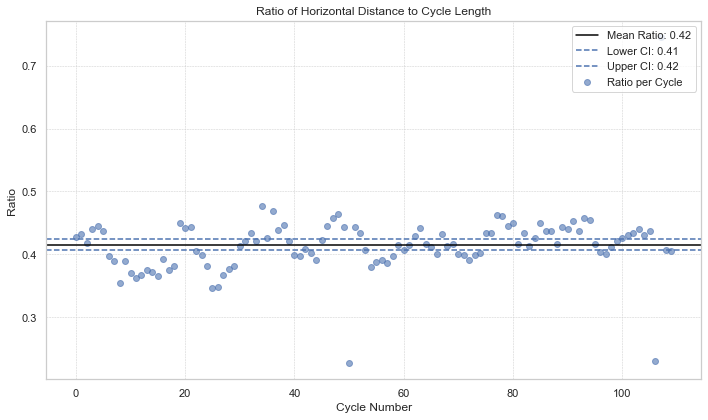

In [191]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# 假定calculate_ratio函数、ppg_data、dicrotic_notches、troughs等已经定义好

# 假定ratios计算已经完成
# ratios = calculate_ratio(ppg_data, dicrotic_notches, troughs)

# 计算置信区间
confidence_interval = stats.t.interval(0.95, len(ratios)-1, loc=np.mean(ratios), scale=stats.sem(ratios))

# 使用Seaborn美化绘图
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.scatter(range(len(ratios)), ratios, alpha=0.6, label='Ratio per Cycle')
plt.axhline(y=np.mean(ratios), color='black', linestyle='-', label=f'Mean Ratio: {mean_ratio:.2f}')
# 绘制置信区间
plt.axhline(y=confidence_interval[0], color='b', linestyle='--', label=f'Lower CI: {confidence_interval[0]:.2f}')
plt.axhline(y=confidence_interval[1], color='b', linestyle='--', label=f'Upper CI: {confidence_interval[1]:.2f}')

plt.xlabel('Cycle Number')
plt.ylabel('Ratio')
plt.title('Ratio of Horizontal Distance to Cycle Length')
plt.legend(loc='upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


使用有二尖瓣波值的二尖瓣波值在波形中占比的置信区间终点重新标注二尖瓣波值

Distance for notch at index 744: 7687.166331382936
Distance for notch at index 1525: 6563.172986335228
Distance for notch at index 2310: 7494.622446245827
Distance for notch at index 3063: 7722.050293083194
Distance for notch at index 3775: 7102.669523124023
Distance for notch at index 4514: 8183.765760533709
Distance for notch at index 5297: 8223.490523356653
Distance for notch at index 6113: 7004.203523194551
Distance for notch at index 6942: 11198.750446237927
Distance for notch at index 7757: 6048.202725831
Distance for notch at index 8557: 7487.3116448283645
Distance for notch at index 9389: 8847.753580548168
Distance for notch at index 10247: 8834.910404579625
Distance for notch at index 11098: 8494.47804745133
Distance for notch at index 11926: 7858.196447405358
Distance for notch at index 12746: 8018.6539579916625
Distance for notch at index 13570: 8043.30126764953
Distance for notch at index 14388: 8118.060568932029
Distance for notch at index 15196: 8241.368812272538
Distance

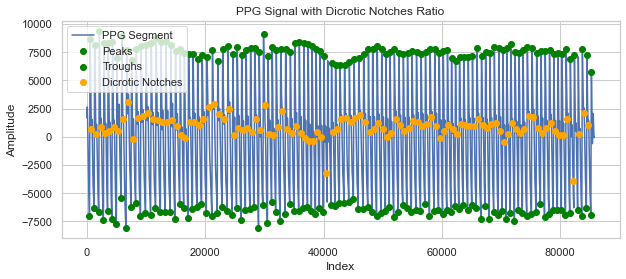

In [192]:
import numpy as np
from scipy.signal import find_peaks
def find_dicrotic_notches_by_ratio(signal, peaks, troughs, ratio=0.42):
    notches = []
    for i in range(len(troughs)-1):
        start_trough = troughs[i]
        end_trough = troughs[i+1]
        cycle_length = end_trough - start_trough
        expected_notch_position = start_trough + int(cycle_length * ratio)
        if expected_notch_position not in peaks:
            notches.append(expected_notch_position)
    return notches



# 找到峰值和波谷
peaks, _ = find_peaks(ppg_segment, distance = distances)
troughs, _ = find_peaks(-ppg_segment, distance = distances)

# 找到二尖瓣波值
dicrotic_notches = find_dicrotic_notches_by_ratio(ppg_segment, peaks, troughs)

# 计算垂直距离并打印
vertical_distances = []
for notch in dicrotic_notches:
    nearest_trough_index = np.argmin(np.abs(troughs - notch))
    nearest_trough = troughs[nearest_trough_index]
    vertical_distance = np.abs(ppg_segment[notch] - ppg_segment[nearest_trough])
    vertical_distances.append(vertical_distance)
    print(f"Distance for notch at index {notch}: {vertical_distance}")

# 计算均值
mean_distance = np.mean(vertical_distances)
print(f"Mean vertical distance: {mean_distance}")


# 计算比率并存储
DR = mean_distance / DC_value
print(f"Dicrotic Notch Component to DC Component Ratio: {DR}")
# 绘制原始信号，并标注峰值和谷值
plt.figure(figsize=(10, 4))
plt.plot(ppg_segment, label='PPG Segment')
plt.scatter(peaks, ppg_segment[peaks], color='green', marker='o', zorder=5, label='Peaks')
plt.scatter(troughs, ppg_segment[troughs], color='green', marker='o', zorder=5, label='Troughs')
# 标注二尖瓣波值
plt.scatter(dicrotic_notches, ppg_segment[dicrotic_notches], color='orange', marker='o', zorder=5, label='Dicrotic Notches')
plt.title('PPG Signal with Dicrotic Notches Ratio')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


计算ppg波的各个线下面积参数 首先PPG波矩形面积（周期内矩形框出的PPG波形面积）与PPG波总线下面积（底边以及PPG波与底边围成的线下面积）绘图并输出面积参数

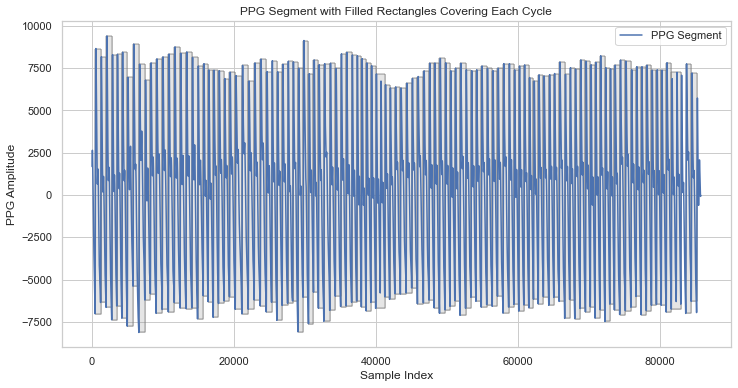

[12226917.013279507, 11377057.046918245, 12626640.939276524, 11068209.601141214, 10709502.419684725, 12026233.63551327, 11897413.66961887, 11809022.375138331, 13223983.632329252, 10255044.676951805, 11127665.912812117, 12847088.530051444, 12872096.880605688, 12769745.330385685, 12285496.500289304, 12482108.167590212, 12424933.533325136, 12063695.308617048, 11926934.880664943, 9476850.998313043, 9887840.447565556, 10869352.394856796, 10827692.818104662, 9985566.368715273, 10712385.169518648, 12809199.581770718, 13346051.460635645, 11280331.763947137, 11993963.029042808, 12371399.132109445, 10499435.677183116, 10782670.621963406, 10874477.379393375, 10896498.620252809, 10080307.90735585, 10595886.51371481, 11421861.117511053, 11596094.561894316, 10431806.176315874, 9525413.155165842, 10938052.65763819, 12594182.43256251, 11551731.549913742, 10097613.860408178, 11501389.636473317, 11610923.510954875, 10347040.882363284, 9684124.948970104, 9826409.868791863, 9834277.638584414, 9430897.0883

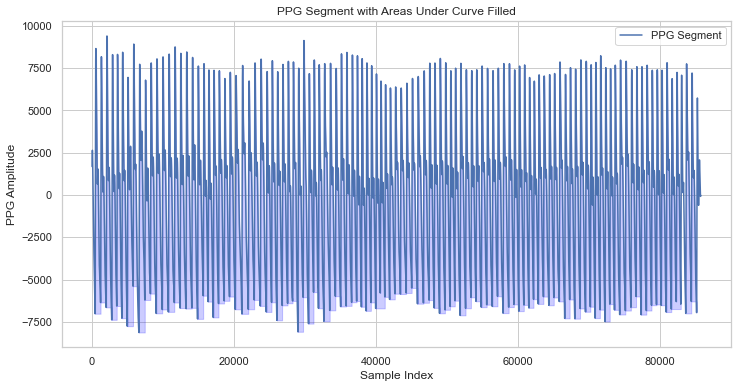

[5579101.532254355, 4835195.043571947, 5297416.998302449, 5269178.202720452, 4761175.455083128, 5467931.550422385, 6444608.187807243, 3964267.345992307, 7330846.51952269, 4682811.286820498, 4631083.267768356, 5984650.479293986, 5855031.040250932, 5731603.914397241, 5279513.78023066, 5445373.936847599, 5564735.124939661, 5459077.253023972, 5994235.737828568, 4204161.560676459, 4300623.0436414275, 5463360.693901387, 5128634.972560135, 4624559.521156456, 4800875.075518273, 6117823.247878571, 6534571.699476233, 5666128.469447676, 5162301.129653443, 5737953.257962795, 5152131.815130438, 4793071.697418464, 5427068.252475694, 5125143.101823589, 4334321.84470283, 4775667.004695441, 5752765.684733994, 4816895.197093631, 5439293.507347718, 3892108.0920393113, 4869025.237170235, 6395915.380463114, 5380531.931698745, 4344391.72413265, 5213067.303637281, 5039861.951552822, 4597434.829023422, 4249798.633986379, 4299889.692879865, 4723683.3675671555, 4301399.373475824, 8587765.282795934, 4076086.6341

In [193]:
#数据传入
new_peaks_s = peaks
new_troughs_s = troughs
new_dicrotic_notches_s = dicrotic_notches
ppg_s = ppg_segment

def calculate_S1(signal, peaks, troughs):
    S1_areas = []
    cycle_rectangles = []

    # 遍历每对相邻的波谷，计算周期并框出矩形
    for i in range(len(troughs) - 1):
        cycle_start = troughs[i]
        cycle_end = troughs[i + 1]
        cycle_length = cycle_end - cycle_start  # 短边：波谷到波谷的距离

        # 在这个周期内找到最高的波峰值
        peaks_in_cycle = [peak for peak in peaks if cycle_start <= peak < cycle_end]
        if not peaks_in_cycle:  # 如果周期内没有波峰，则跳过
            continue
        max_peak = max(peaks_in_cycle, key=lambda peak: signal[peak])
        amplitude = signal[max_peak] - signal[cycle_start]  # 长边：最大波峰与波谷的垂直距离

        # 计算矩形面积
        area = cycle_length * amplitude
        S1_areas.append(area)

        # 保存矩形的边界以便绘图
        cycle_rectangles.append((cycle_start, cycle_end, signal[cycle_start], signal[max_peak]))

    return S1_areas, cycle_rectangles

# 计算S1面积和周期矩形
S1_areas, cycle_rectangles = calculate_S1(ppg_s, new_peaks_s, new_troughs_s)

# 绘制带有周期矩形的PPG波形，并在矩形内填充颜色

plt.figure(figsize=(12, 6))
plt.plot(ppg_s, label='PPG Segment')
for rect in cycle_rectangles:
    plt.hlines(y=[rect[2], rect[3]], xmin=rect[0], xmax=rect[1], color='grey', alpha=0.5)
    plt.vlines(x=[rect[0], rect[1]], ymin=rect[2], ymax=rect[3], color='grey', alpha=0.5)
    plt.fill_betweenx(y=[rect[2], rect[3]], x1=rect[0], x2=rect[1], color='grey', alpha=0.2)
plt.title('PPG Segment with Filled Rectangles Covering Each Cycle')
plt.xlabel('Sample Index')
plt.ylabel('PPG Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# 输出S1面积
print(S1_areas)
def calculate_ppg_area_under_curve(signal, cycle_rectangles):
    # 计算每个周期内PPG波与底部围成的线下面积
    areas_under_curve = []
    for rect in cycle_rectangles:
        cycle_start = rect[0]
        cycle_end = rect[1]
        baseline = rect[2]  # 波谷值作为基线
        area_under_curve = np.trapz(signal[cycle_start:cycle_end] - baseline, dx=1)
        areas_under_curve.append(area_under_curve)
    return areas_under_curve

# 计算线下面积
areas_under_curve = calculate_ppg_area_under_curve(ppg_s, cycle_rectangles)

# 绘制PPG波形，并填充周期内的线下面积
plt.figure(figsize=(12, 6))
plt.plot(ppg_s, label='PPG Segment')
for rect in cycle_rectangles:
    cycle_start = rect[0]
    cycle_end = rect[1]
    baseline = rect[2]
    plt.fill_between(x=range(cycle_start, cycle_end), y1=ppg_s[cycle_start:cycle_end], y2=baseline, color='blue', alpha=0.2)

plt.title('PPG Segment with Areas Under Curve Filled')
plt.xlabel('Sample Index')
plt.ylabel('PPG Amplitude')
plt.legend()
plt.grid(True)
plt.show()

print(areas_under_curve)

PPG波二尖瓣波值与距离较远波谷与底边围城线下面积 绘图并输出相应面积 对于框不出面积的周期不求算

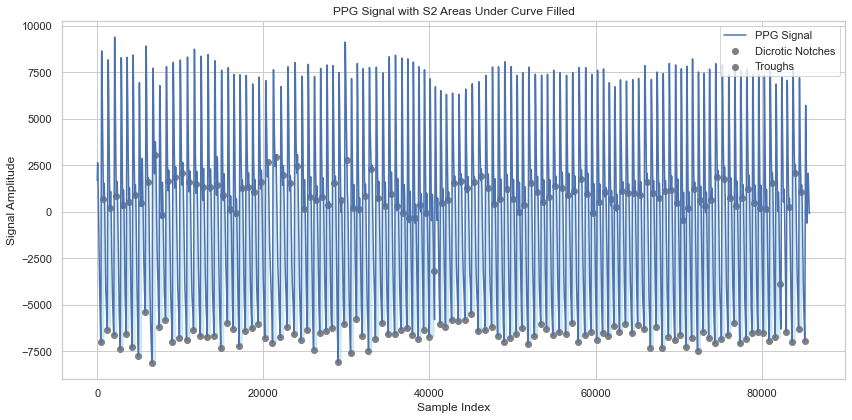

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_S2_and_plot_corrected(signal, troughs, notches, cycle_rectangles):
    S2_areas = []
    S2_rectangles = []

    sns.set(style="whitegrid")

    for rect in cycle_rectangles:
        cycle_start, cycle_end, _, _ = rect
        notches_in_cycle = [notch for notch in notches if cycle_start <= notch <= cycle_end]
        troughs_in_cycle = [trough for trough in troughs if cycle_start <= trough <= cycle_end]

        if not notches_in_cycle or not troughs_in_cycle:  # 如果周期内没有二尖瓣波值或波谷，则跳过
            continue

        notch = notches_in_cycle[0]  # 取周期内第一个二尖瓣波值
        first_trough = troughs_in_cycle[0]  # 取周期内第一个波谷

        # 计算S2面积
        area = np.trapz(signal[first_trough:notch] - signal[first_trough], dx=1)
        S2_areas.append(area)

        # 保存用于绘图的矩形边界
        S2_rectangles.append((first_trough, notch, signal[first_trough], signal[notch]))

    plt.figure(figsize=(12, 6))
    plt.plot(signal, label='PPG Signal')
    for rect in S2_rectangles:
        plt.fill_between(x=range(rect[0], rect[1]), y1=signal[rect[0]:rect[1]], y2=rect[2], color='lightblue', alpha=0.5)

    plt.scatter(notches, signal[notches], color='gray', label='Dicrotic Notches')
    plt.scatter(troughs, signal[troughs], color='gray', label='Troughs')
    #plt.scatter(troughs, signal[peaks], color='orange', label='Troughs')
    plt.title('PPG Signal with S2 Areas Under Curve Filled')
    plt.xlabel('Sample Index')
    plt.ylabel('Signal Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return S2_areas

# 假设ppg_s, new_troughs_s, new_dicrotic_notches_s, cycle_rectangles等变量已经定义
S2_areas_corrected = calculate_S2_and_plot_corrected(ppg_s, new_troughs_s, new_dicrotic_notches_s, cycle_rectangles)


 PPG上升支面积 绘图并输出面积参数

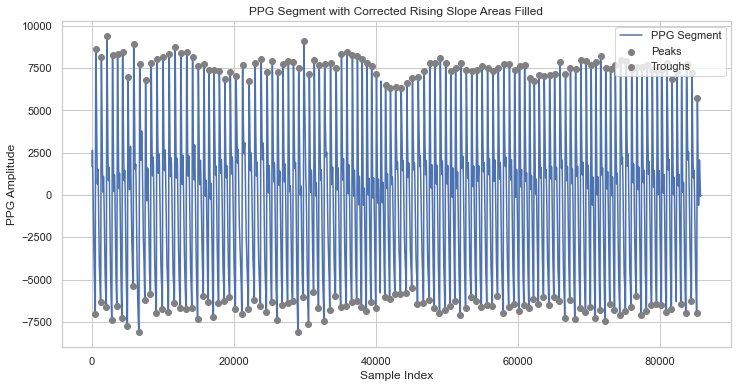

[1025731.9727610708,
 909416.7868106281,
 993303.9516458916,
 1019564.0862304075,
 897619.010060555,
 984859.9116261988,
 882609.7477301933,
 834228.005356153,
 994979.170004501,
 797809.6264053698,
 862833.4936739863,
 936046.0963477202,
 923718.1463441065,
 943266.3933906229,
 908638.0309230767,
 908367.8562325761,
 947064.4252849672,
 957774.9083106918,
 929282.210527669,
 843856.3066432211,
 854959.0694489874,
 898668.1382100594,
 892479.1599793539,
 766089.8954990683,
 809066.1560013116,
 872076.4858337925,
 951975.4578889876,
 912689.4655567124,
 919188.5052577427,
 963771.5140009872,
 941559.7678244953,
 928869.5788742693,
 930154.2376842729,
 907974.0475341699,
 888675.8084574402,
 949419.4600761343,
 991765.5312113418,
 959933.0818603568,
 914308.3022319666,
 796137.8154010661,
 851391.5129516949,
 993920.2452052888,
 925370.4282057037,
 852533.1123370936,
 958930.7115200413,
 884410.0195972462,
 871079.4912921622,
 880738.2686404116,
 859877.5653864169,
 887745.714930662,
 80

In [195]:
def calculate_rising_slope_area_corrected(signal, troughs, peaks):
    # 计算波谷与下一个波峰之间的线下面积
    corrected_rising_slope_areas = []
    corrected_rising_slope_rectangles = []

    for i in range(len(troughs)):
        trough = troughs[i]
        # 找到下一个波峰
        next_peaks = [peak for peak in peaks if peak > trough]
        if not next_peaks:  # 如果没有下一个波峰，则跳过
            continue
        next_peak = next_peaks[0]
        
        # 计算水平距离（底边）
        horizontal_distance = next_peak - trough
        # 垂直位置取波谷的位置
        trough_level = signal[trough]

        # 计算线下面积
        area = np.trapz(signal[trough:next_peak] - trough_level, dx=1)
        corrected_rising_slope_areas.append(area)

        # 保存矩形的边界以便绘图
        corrected_rising_slope_rectangles.append((trough, next_peak, trough_level, signal[next_peak]))

    return corrected_rising_slope_areas, corrected_rising_slope_rectangles

# 计算修正后的上升支的面积
corrected_rising_slope_areas, corrected_rising_slope_rectangles = calculate_rising_slope_area_corrected(ppg_s, new_troughs_s, new_peaks_s)

# 绘制PPG波形，并填充修正后的上升支区域
plt.figure(figsize=(12, 6))
plt.plot(ppg_s, label='PPG Segment')
for rect in corrected_rising_slope_rectangles:
    plt.fill_between(x=range(rect[0], rect[1]), y1=ppg_s[rect[0]:rect[1]], y2=rect[2], color='lightgray', alpha=0.3)
plt.scatter(new_peaks_s, ppg_s[new_peaks_s], color='gray', marker='o', zorder=5, label='Peaks')
plt.scatter(new_troughs_s, ppg_s[new_troughs_s], color='gray', marker='o', zorder=5, label='Troughs')
plt.title('PPG Segment with Corrected Rising Slope Areas Filled')
plt.xlabel('Sample Index')
plt.ylabel('PPG Amplitude')
plt.legend()
plt.grid(True)
plt.show()

corrected_rising_slope_areas


分别取PPG波各个面积参数的平均值 矩形面积 线下面积 到二尖瓣波值的线下面积 上升支面积

In [196]:
# 计算S1_areas, areas_under_curve, S2_areas_corrected, corrected_rising_slope_areas的平均值
average_S1 = sum(S1_areas) / len(S1_areas)
average_areas_under_curve = sum(areas_under_curve)  / len(areas_under_curve)
average_S2_corrected = sum(S2_areas_corrected) / len(S2_areas_corrected)
average_corrected_rising_slope = sum(corrected_rising_slope_areas) / len(corrected_rising_slope_areas)

average_S1, average_areas_under_curve, average_S2_corrected, average_corrected_rising_slope
R1 = average_areas_under_curve/average_S1
a = average_areas_under_curve - average_S2_corrected
R2 = average_S2_corrected / a
R3 = average_corrected_rising_slope / average_S1
R4 = average_S2_corrected / average_S1
print(R1,R2,R3,R4)

0.46422803873954593 1.4679001403954985 0.08497413574570668 0.2761215464464056


求算脉搏波动力学参数 上升支垂直距离除以上升支时间 二尖瓣波值垂直距离除以二尖瓣波值对应心脏舒张期时间 二者比值相加 将参数在图中标注

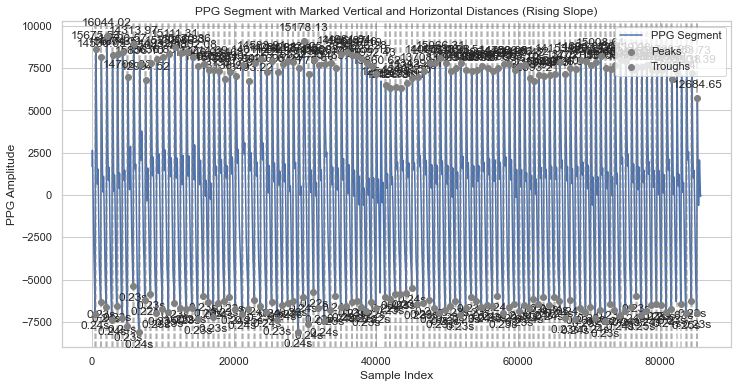

([15675.534632409624,
  14530.085628248078,
  16044.01644126623,
  15677.35070983175,
  14874.308916228783,
  15720.566843808198,
  14706.320976043102,
  14313.966515319189,
  15856.095482409175,
  12997.521770534608,
  13636.845481387398,
  15043.42919209771,
  14932.82700766321,
  15238.359582799147,
  15111.311808473929,
  15056.82529262993,
  15170.859015049005,
  14802.080133272451,
  14946.033685043789,
  13714.690301466053,
  13695.069871974454,
  14609.344616743005,
  13758.186554135531,
  13138.903116730622,
  13257.902437523078,
  13817.906776451691,
  14682.124819181128,
  13493.219813333895,
  14011.639052620103,
  14588.914070883779,
  14207.626085498126,
  14281.68294299789,
  14695.23970188294,
  14243.789046082104,
  14298.309088448015,
  14127.848684953082,
  15582.34804571767,
  15178.134243317169,
  14775.929428209454,
  13725.379186117929,
  14392.174549523934,
  15228.757475891789,
  14603.958975870722,
  13463.485147210904,
  14936.869657757554,
  14981.8367883288

In [197]:
def calculate_vertical_horizontal_distances_corrected(signal, troughs, peaks, sampling_rate):
    # 初始化垂直距离和水平距离的列表
    vertical_distances_corrected = []
    horizontal_times_corrected = []  # 水平距离转换为时间

    # 遍历每个波谷和下一个波峰
    for trough in troughs:
        # 找到下一个波峰
        next_peaks = [peak for peak in peaks if peak > trough]
        if not next_peaks:
            continue
        next_peak = next_peaks[0]

        # 计算垂直距离和水平距离
        vertical_distance = signal[next_peak] - signal[trough]
        horizontal_distance = next_peak - trough
        # 将水平距离转换为时间（秒）
        time_duration = horizontal_distance / sampling_rate

        vertical_distances_corrected.append(vertical_distance)
        horizontal_times_corrected.append(time_duration)

    return vertical_distances_corrected, horizontal_times_corrected

# 重新计算垂直和水平距离
vertical_distances_corrected, horizontal_times_corrected = calculate_vertical_horizontal_distances_corrected(ppg_s, new_troughs_s, new_peaks_s, 500)

# 修改代码，以标注周期内波谷到波峰（上升段）的垂直与水平距离
plt.figure(figsize=(12, 6))
plt.plot(ppg_s, label='PPG Segment')
plt.scatter(new_peaks_s, ppg_s[new_peaks_s], color='gray', marker='o', zorder=5, label='Peaks')
plt.scatter(new_troughs_s, ppg_s[new_troughs_s], color='gray', marker='o', zorder=5, label='Troughs')
for i in range(min(len(new_troughs_s), len(vertical_distances_corrected))):
    trough = new_troughs_s[i]

    # 确保不会超出 new_peaks_s 的索引范围
    if i >= len(new_peaks_s):
        break
    peak = new_peaks_s[i]

    plt.annotate(f"{vertical_distances_corrected[i]:.2f}", (peak, ppg_s[peak]), textcoords="offset points", xytext=(0,10), ha='center')

    # 检查 horizontal_times_corrected 索引是否有效
    if i < len(horizontal_times_corrected):
        plt.annotate(f"{horizontal_times_corrected[i]:.2f}s", ((trough+peak)/2, ppg_s[trough]), textcoords="offset points", xytext=(0,-15), ha='center')

    # 绘制垂直虚线
    plt.axvline(x=trough, color='grey', linestyle='--', alpha=0.5)
    plt.axvline(x=peak, color='grey', linestyle='--', alpha=0.5)
    # 绘制水平虚线
    plt.hlines(y=ppg_s[trough], xmin=peak, xmax=trough, color='grey', linestyle='--', alpha=0.5)

plt.title('PPG Segment with Marked Vertical and Horizontal Distances (Rising Slope)')
plt.xlabel('Sample Index')
plt.ylabel('PPG Amplitude')
plt.legend()
plt.grid(True)
plt.show()

vertical_distances_corrected, horizontal_times_corrected


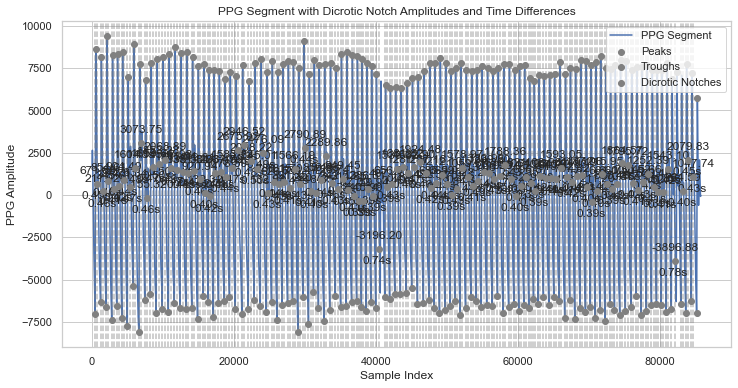

([671.8812233357768,
  211.9228955459764,
  854.6070554695538,
  345.60720094558343,
  542.6333604627864,
  904.4857564514925,
  471.33872115387965,
  1614.1382935716347,
  3073.7503388676223,
  -155.32332506446235,
  1659.6434649027788,
  1853.2340914252004,
  2068.8877216580345,
  1587.9778519684949,
  1503.5118069963462,
  1338.501995906705,
  1331.807898844302,
  1449.3100329613003,
  920.9438503371377,
  132.31941049080703,
  -82.70650133250595,
  1296.4536192947203,
  1337.7636630179848,
  1078.59493096257,
  1583.2245094771254,
  2675.9185839485676,
  2946.5194958979746,
  2008.2161885148926,
  1545.0070352594953,
  2476.091378722978,
  132.92687207188885,
  780.154996268871,
  626.709508073633,
  781.7014470961747,
  391.35064557362557,
  1566.193099133409,
  633.4677353416271,
  2790.889495295522,
  220.69677394956074,
  148.64709036801045,
  859.958254183908,
  2289.8639453322016,
  723.7420012393284,
  342.5206913325346,
  949.452886583672,
  314.849734188205,
  -67.01898588

In [198]:
def calculate_dicrotic_notch_distances(signal, troughs, notches, sampling_rate):
    # 初始化二尖瓣波值的纵坐标和与下一个波谷的水平距离差值
    dicrotic_notch_amplitudes = []
    horizontal_time_differences = []

    # 遍历每个二尖瓣波值
    for notch in notches:
        # 找到下一个波谷
        next_troughs = [trough for trough in troughs if trough > notch]
        if not next_troughs:
            continue
        next_trough = next_troughs[0]

        # 计算二尖瓣波值的纵坐标
        dicrotic_notch_amplitude = signal[notch]
        dicrotic_notch_amplitudes.append(dicrotic_notch_amplitude)

        # 计算水平距离差值并转换为时间
        horizontal_distance = next_trough - notch
        time_difference = horizontal_distance / sampling_rate
        horizontal_time_differences.append(time_difference)

    return dicrotic_notch_amplitudes, horizontal_time_differences

# 计算二尖瓣波值的纵坐标和水平时间差
dicrotic_notch_amplitudes, horizontal_time_differences = calculate_dicrotic_notch_distances(ppg_s, new_troughs_s, new_dicrotic_notches_s, 1000)

# 绘制ppg_s的波形并标注
plt.figure(figsize=(12, 6))
plt.plot(ppg_s, label='PPG Segment')
plt.scatter(new_peaks_s, ppg_s[new_peaks_s], color='gray', marker='o', zorder=5, label='Peaks')
plt.scatter(new_troughs_s, ppg_s[new_troughs_s], color='gray', marker='o', zorder=5, label='Troughs')
plt.scatter(new_dicrotic_notches_s, ppg_s[new_dicrotic_notches_s], color='gray', zorder=5, label='Dicrotic Notches')

# 标注水平时间差和二尖瓣波值的纵坐标
for i, notch in enumerate(new_dicrotic_notches_s):
    if i >= len(new_troughs_s) or i >= len(horizontal_time_differences):
        break
    next_trough = new_troughs_s[i]
    plt.annotate(f"{dicrotic_notch_amplitudes[i]:.2f}", (notch, ppg_s[notch]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f"{horizontal_time_differences[i]:.2f}s", ((notch+next_trough)/2, ppg_s[notch]), textcoords="offset points", xytext=(0,-15), ha='center')

    # 画垂直虚线
    plt.axvline(x=notch, color='grey', linestyle='--', alpha=0.5)
    plt.axvline(x=next_trough, color='grey', linestyle='--', alpha=0.5)

plt.title('PPG Segment with Dicrotic Notch Amplitudes and Time Differences')
plt.xlabel('Sample Index')
plt.ylabel('PPG Amplitude')
plt.legend()
plt.grid(True)
plt.show()

dicrotic_notch_amplitudes, horizontal_time_differences


求算比值后相加得到脉搏波动力学参数

In [199]:
# 使用NumPy进行逐元素的除法
import numpy as np
import pandas as pd
dicrotic_notch_amplitudes_abs = np.abs(dicrotic_notch_amplitudes)
# 确保列表转换为NumPy数组
dicrotic_notch_amplitudes_abs_np = np.array(dicrotic_notch_amplitudes_abs)
horizontal_time_differences_np = np.array(horizontal_time_differences)
vertical_distances_corrected_np = np.array(vertical_distances_corrected)
horizontal_times_corrected_np = np.array(horizontal_times_corrected)

# 确保数组长度相同，以最短数组长度为准
min_length = min(len(dicrotic_notch_amplitudes_abs_np), len(horizontal_time_differences_np))
ratio_amplitude_time = dicrotic_notch_amplitudes_abs_np[:min_length] / horizontal_time_differences_np[:min_length]

min_length = min(len(vertical_distances_corrected_np), len(horizontal_times_corrected_np))
ratio_vertical_horizontal = vertical_distances_corrected_np[:min_length] / horizontal_times_corrected_np[:min_length]

print(ratio_amplitude_time)
print(ratio_vertical_horizontal)
# 计算ratio_amplitude_time和ratio_vertical_horizontal的平均值并相加
average_ratio_amplitude_time = np.mean(ratio_amplitude_time) if ratio_amplitude_time.size > 0 else 0
average_ratio_vertical_horizontal = np.mean(ratio_vertical_horizontal) if ratio_vertical_horizontal.size > 0 else 0

sum_of_averages = average_ratio_amplitude_time + average_ratio_vertical_horizontal
print(sum_of_averages)


[1483.18150847  465.7646056  1870.0373205   842.94439255 1298.16593412
 2037.1300821  1002.84834288 3369.80854608 6350.72384064  339.13389752
 3501.35752089 3736.35905529 4137.77544332 3260.73480897 3185.40637075
 2782.74843224 2797.91575387 3064.08040795 1989.07959036  329.97359225
  197.39021798 3001.05004466 2927.2727856  2445.79349425 3375.74522277
 4973.82636422 5580.52934829 4140.65193508 3108.66606692 5032.70605431
  309.85284865 1781.17579057 1457.46397226 1760.58884481  956.84754419
 3600.44390605 1487.01346324 6285.78715157  538.28481451  368.85134086
 1950.01871697 4770.54988611 1576.77995913  787.40388812 2124.05567468
  699.66607597  163.063226    876.6366659   889.43602093  990.53281999
  153.28745412 4290.20724248 1186.434295   1541.10742041 3376.3542839
 3585.53801992 2816.62713111 3452.22738005 3959.82761942 2826.0621929
 1005.49554485 1558.15449453 2736.10804185 1596.71691434   51.0104255
  858.84184875 3524.48329903 2397.41115837 1276.79535143 1869.0990529
 3117.0261

计算lnDC 表征高阶分量

In [200]:
import numpy as np

# 计算DC值的自然对数
log_DC_value = np.log(DC_value)
log_DC_value 


13.471099902998109

这是直接将运算结果写入excel表的程序 使用os交互指令 在桌面上新建excel文件 a追加模式

In [201]:
parameters = {
    'bpm': m['bpm'],
    'ibi': m['ibi'],
    'sdnn': m['sdnn'],
    'sdsd': m['sdsd'],
    'rmssd': m['rmssd'],
    'pnn20': m['pnn20'],
    'pnn50': m['pnn50'],
    'hr_mad': m['hr_mad'],
    'sd1': m['sd1'],
    'sd2': m['sd2'],
    's': m['s'],
    'sd1/sd2': m['sd1/sd2'],
    'breathingrate': m['breathingrate']
}
    
m['bpm'] = m['bpm'] 
m['ibi'] = m['ibi'] 
print(m['bpm'])
print(m['ibi'])

79.78357558805997
752.0344827586207


In [202]:
from openpyxl import load_workbook
import os
from openpyxl import Workbook

# 定义数据字典
data_to_save = {
    "Average Breathing Interval ":  m['breathingrate'],
    "Breathing Period Variability ": breathing_period_variability,
    "Average Heartbeat Interval ": m['bpm'],
    "Heartbeat Period Variability ":  m['ibi'],
    "R1 AC/DC Component Ratio ": R,
    "Dicrotic Notch Component to DC Component Ratio ": DR,
    "Average Area of PPG Waveform Bounded by Rectangle ": average_S1,
    "Average Area Under PPG Waveform Curve ": average_areas_under_curve,
    "Average Area Under PPG Waveform Between Dicrotic Notch and First Trough ":average_S2_corrected,
    "Average Area of PPG Waveform Rising Slope ": average_corrected_rising_slope,
    "PPG Pulse Wave Dynamics Parameters ": sum_of_averages,
    "Average DC Component ": DC_value,
    "ln Average DC Component ": log_DC_value,
    "Average Amplitude": Altitude,
    "Amplitude Variation Period ": period_true,
    "Average Component of Dicrotic Notch ": average_distance,
    "R1":R1,
    "R2":R2,
    "R3":R3,
    "R4":R4,
    "sdnn": m['sdnn'],
    "sdsd": m['sdsd'],
    "rmssd": m['rmssd'],
    "pnn20": m['pnn20'],
    "pnn50": m['pnn50'],
    "hr_mad": m['hr_mad'],
    "sd1": m['sd1'],
    "sd2": m['sd2'],
    "s": m['s'],
    "sd1/sd2": m['sd1/sd2'],
    
}

# 设置文件路径
desktop_path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')
file_name = "PPG_Data.xlsx"
file_path = os.path.join(desktop_path, file_name)

# 检查文件是否存在，如果不存在，则创建
if not os.path.exists(file_path):
    wb = Workbook()
    ws = wb.active
    ws.append(list(data_to_save.keys()))
    wb.save(file_path)

# 加载现有的工作簿
wb = load_workbook(file_path)
ws = wb.active

# 追加一行数据
ws.append(list(data_to_save.values()))

# 保存工作簿
wb.save(file_path)

file_path  # 返回文件路径



'C:\\Users\\HUAWEI\\Desktop\\PPG_Data.xlsx'

In [203]:
import os
import pandas as pd
import numpy as np
import torch

def find_global_min_max(data_directory, columns_of_interest):
    min_values = {}
    max_values = {}

    # 初始化最大值和最小值为None
    for column in columns_of_interest:
        min_values[column] = None
        max_values[column] = None

    # 遍历文件夹中的所有Excel文件
    for filename in os.listdir(data_directory):
        if filename.endswith('.xlsx'):
            file_path = os.path.join(data_directory, filename)
            df = pd.read_excel(file_path)

            # 如果 'CO' 列不存在，则添加并填充为0
            if 'CO' not in df.columns:
                df['CO'] = 0

            # 使用感兴趣的列进行处理
            df = df[columns_of_interest]
            
            # 更新最大值和最小值
            for column in columns_of_interest:
                if min_values[column] is None or df[column].min() < min_values[column]:
                    min_values[column] = df[column].min()
                if max_values[column] is None or df[column].max() > max_values[column]:
                    max_values[column] = df[column].max()

    return min_values, max_values

data_directory = r"C:\Users\HUAWEI\Desktop\data"
columns_of_interest = [
    'Average Heartbeat Interval ',
    'Heartbeat Period Variability ',
    'R1 AC/DC Component Ratio ',
    'Dicrotic Notch Component to DC Component Ratio ',
    'Average Area of PPG Waveform Bounded by Rectangle ',
    'Average Area Under PPG Waveform Curve ',
    'Average Area Under PPG Waveform Between Dicrotic Notch and First Trough ',
    'Average Area of PPG Waveform Rising Slope ',
    'PPG Pulse Wave Dynamics Parameters ',
    'ln Average DC Component ',
    'R1',
    'R2',
    'R3',
    'R4',
    'sdnn',
    'sdsd',
    'rmssd',
    'pnn20',
    'pnn50',
    'hr_mad',
    'sd1',
    'sd2',
    's',
    'sd1/sd2',
    'CO'
]

# 找到全局最大值和最小值
min_values, max_values = find_global_min_max(data_directory, columns_of_interest)

# 对除了 'CO' 之外的数据进行归一化
data_to_normalize = np.array([data_to_save[column] for column in columns_of_interest if column != 'CO'])

# 进行归一化
normalized_data = np.array([(data_to_normalize[i] - min_values[columns_of_interest[i]]) / 
                            (max_values[columns_of_interest[i]] - min_values[columns_of_interest[i]]) 
                            for i in range(len(data_to_normalize))])

# 转换为张量
data_tensor = torch.tensor(normalized_data, dtype=torch.float32)

print(data_tensor)

tensor([0.1758, 0.6061, 0.3298, 0.2975, 0.6677, 0.5756, 0.4585, 0.1338, 0.3194,
        1.1046, 0.5528, 0.0504, 0.0525, 0.3796, 0.3239, 0.1576, 0.1631, 0.6261,
        0.2007, 0.2500, 0.1629, 0.3602, 0.0773, 0.0664])


In [204]:

import ppg_package.model as model
import matplotlib.pyplot  as plt
plt.close()

In [205]:
from ppg_package.utils import read_and_predict_with_tensor
import matplotlib.pyplot as plt

plt.close()

In [206]:
import numpy as np
import torch
from ppg_package.utils import read_and_predict_with_tensor
import matplotlib.pyplot as plt

plt.close()

# 定义模型路径
model_path = r"C:\Users\HUAWEI\Desktop\model_weights_fold_10 (1).pth"




if data_tensor.dim() == 1:
    data_tensor = data_tensor.unsqueeze(0)

# 使用模型进行预测
predictions = read_and_predict_with_tensor(data_tensor, model_path,columns_of_interest)

# 打印预测结果
for pred in predictions:
    print(f"Deep learning model Predictions CO:{pred}\n")
import pandas as pd
import os

def find_CO_min_max(data_directory, file_pattern='.xlsx', co_column_name='CO'):
    min_CO = float('inf')
    max_CO = float('-inf')

    # 遍历文件夹中的所有Excel文件
    for filename in os.listdir(data_directory):
        if filename.endswith(file_pattern):
            file_path = os.path.join(data_directory, filename)
            df = pd.read_excel(file_path)

            # 如果CO列存在，则更新最大值和最小值
            if co_column_name in df.columns:
                min_CO = min(min_CO, df[co_column_name].min())
                max_CO = max(max_CO, df[co_column_name].max())

    return min_CO, max_CO

# 定义数据目录
data_directory = r"C:\Users\HUAWEI\Desktop\data"

# 获取CO列的最大值和最小值
min_CO, max_CO = find_CO_min_max(data_directory)

a = m['bpm'] / 60
# 逆归一化预测结果
unnormalized_predictions = [(a*pred * (max_CO - min_CO) + min_CO).item() for pred in predictions]

# 打印逆归一化后的预测结果
for unnormalized_pred in unnormalized_predictions:
    print(f"Deep learning model Predictions CO (Unnormalized): {unnormalized_pred}\n")


Deep learning model Predictions CO:tensor([[0.3273]])

Deep learning model Predictions CO (Unnormalized): 3.8115158081054688

